In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='ticks', context='talk')

%matplotlib inline
import flotilla

folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure1_supplementary'

# study = flotilla.embark('singlecell_pnm_post_kmeans_outliers')
study = flotilla.embark('singlecell_pnm_figure1_post_kmeans_outliers')

2015-09-24 15:26:34	Reading datapackage from /home/obotvinnik/flotilla_projects/singlecell_pnm_figure1_post_kmeans_outliers/datapackage.json
2015-09-24 15:26:34	Parsing datapackage to create a Study object
2015-09-24 15:27:24	Initializing Study
2015-09-24 15:27:24	Initializing Predictor configuration manager for Study
2015-09-24 15:27:24	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-09-24 15:27:24	Added ExtraTreesClassifier to default predictors
2015-09-24 15:27:24	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-09-24 15:27:24	Added ExtraTreesRegressor to default predictors
2015-09-24 15:27:24	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-09-24 15:27:24	Added GradientBoostingClassifier to default predictors
2015-09-24 15:27:24	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.grad

In [2]:
mkdir $folder

mkdir: cannot create directory `/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure1_supplementary': File exists


## Expression Quality Control
### Number of detected genes

8023.68224299
phenotype
MN      7667.780822
NPC     7594.407895
iPSC    8925.307692
dtype: float64


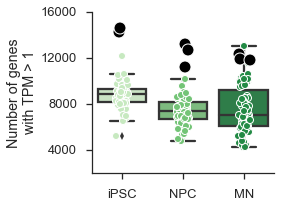

In [3]:
sns.set(context='talk', style='ticks')

detected_genes = (study.expression.data_original > 1).sum(axis=1)

print detected_genes.mean()
print detected_genes.groupby(study.sample_id_to_phenotype).mean()

detected_genes = detected_genes.to_frame().join(study.metadata.data[['pooled', 'phenotype']])
detected_genes = detected_genes.rename(columns={0: 'n_genes_detected'})

detected_genes_pooled = detected_genes.ix[detected_genes.pooled]
detected_genes_single = detected_genes.ix[~detected_genes.pooled]

fig, ax = plt.subplots(figsize=(4, 3))
sns.boxplot(x='phenotype', y='n_genes_detected', order=study.phenotype_order, 
               data=detected_genes_single, palette=study.phenotype_color_ordered)
sns.stripplot(x='phenotype', y='n_genes_detected', order=study.phenotype_order,
               data=detected_genes_single, palette=study.phenotype_color_ordered, jitter=True)
sns.stripplot(x='phenotype', y='n_genes_detected', order=study.phenotype_order,
              data=detected_genes_pooled, color='k', size=12, jitter=True)
sns.despine()
ax.set_xlabel('')

ax.set_ylabel('Number of genes\nwith TPM > 1')

# Reduce number of ticks
yloc = plt.MaxNLocator(5)
ax.yaxis.set_major_locator(yloc)

sns.despine()
fig.tight_layout()
fig.savefig('{}/detected_genes.pdf'.format(folder))

### Number of detected genes, per transcript type

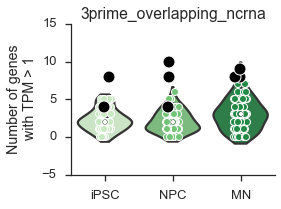

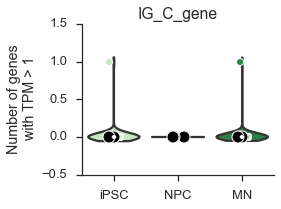

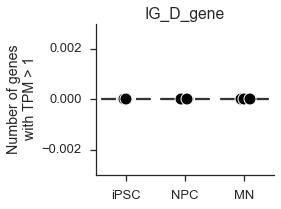

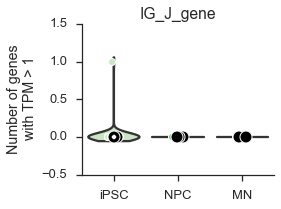

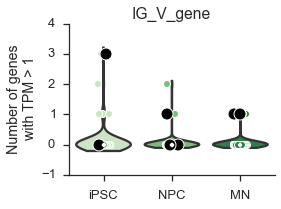

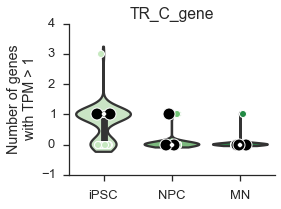

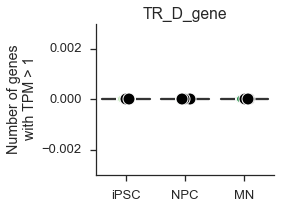

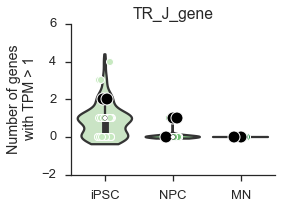

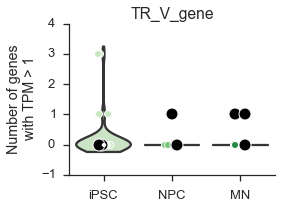

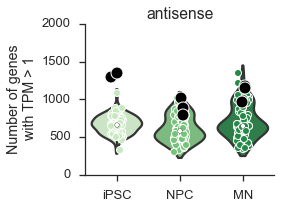

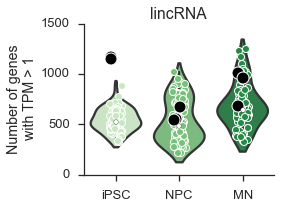

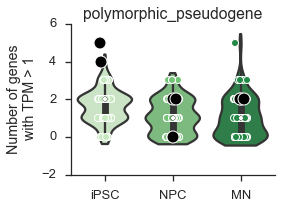

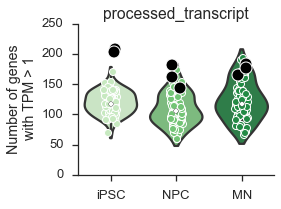

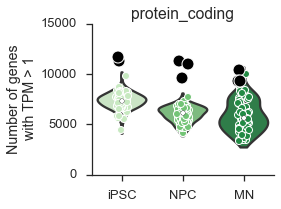

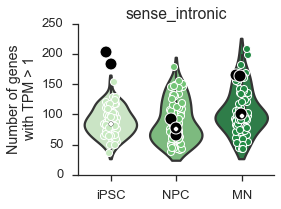

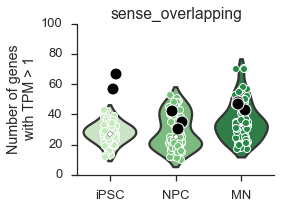

In [4]:
grouped = study.expression.data_original.groupby(study.expression.feature_data.transcript_type, axis=1)
detected_genes = grouped.apply(lambda x:  (x > 1).sum(axis=1))

# # print detected_genes.groupby(study.sample_id_to_phenotype).mean()

for transcript_type, df in detected_genes.iterkv():
    df = df.to_frame().join(study.metadata.data[['pooled', 'phenotype']])
    detected_genes_pooled = df.ix[df.pooled]
    detected_genes_single = df.ix[~df.pooled]

    fig, ax = plt.subplots(figsize=(4, 3))
    sns.violinplot(x='phenotype', y=transcript_type, order=study.phenotype_order, 
                   data=detected_genes_single, palette=study.phenotype_color_ordered,
                  cut=True, scale='width')
    sns.stripplot(x='phenotype', y=transcript_type, order=study.phenotype_order,
                   data=detected_genes_single, palette=study.phenotype_color_ordered, jitter=True)
    sns.stripplot(x='phenotype', y=transcript_type, order=study.phenotype_order,
                  data=detected_genes_pooled, color='k', size=12, jitter=True)
    sns.despine()
    ax.set(title=transcript_type, xlabel='', ylabel='Number of genes\nwith TPM > 1')

    # Reduce number of ticks on the y axis
    ax.locator_params('y', nbins=5)

    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/detected_genes_{}.pdf'.format(folder, transcript_type))

### Differentially expressed genes between outliers and non-outliers

Focus on just NPC and MN because that's where the majority of the outliers are.

In [5]:
expression = study.expression.singles.ix[study.metadata.data.phenotype.map(lambda x: x in ('MN', 'NPC'))].dropna()
print expression.shape
# Use only genes which have $\log_2(TPM+1) > 1$ in at least 3 cells.
expression = expression.ix[:, (expression > 1).sum() >= 3]
expression.groupby(study.sample_id_to_phenotype).size()

(143, 16028)


phenotype
MN     70
NPC    73
dtype: int64

In [6]:
from scipy.stats import kruskal

grouped = expression.groupby(study.sample_id_to_phenotype)

def outliers_diff_expression(df1):
    # Use only genes which have $\log_2(TPM+1) > 1$ in at least 3 cells.
    df1 = df1.ix[:, (df1 > 1).sum() >= 3].dropna()
    return df1.groupby(level=0, axis=1).apply(lambda df2: pd.Series(kruskal(*[x for name, x in 
                                                                              df2.groupby(study.metadata.data.outlier)]), 
                                                                    index=['H_statistic', 'p_value']))

kruskal_results = grouped.apply(outliers_diff_expression)
kruskal_results.head()

ENSG00000000003  ENSG00000000419  ENSG00000000457  \
phenotype                                                                  
MN        H_statistic         7.322830         7.367251         0.473811   
          p_value             0.006808         0.006642         0.491239   
NPC       H_statistic         0.494155         1.358311         0.236059   
          p_value             0.482080         0.243830         0.627067   

                       ENSG00000000460  ENSG00000001036  ENSG00000001084  \
phenotype                                                                  
MN        H_statistic         1.560843         3.168839         0.002449   
          p_value             0.211542         0.075056         0.960533   
NPC       H_statistic         0.426773         0.482292         0.892931   
          p_value             0.513577         0.487386         0.344684   

                       ENSG00000001167  ENSG00000001460  ENSG00000001461  \
phenotype                                                                  
MN        H_statistic         0.501945     2.543291e+01         1.680846   
          p_value             0.478647     4.580384e-07         0.194812   
NPC       H_statistic         3.813714     1.787887e-01         4.156290   
          p_value             0.050835     6.724163e-01         0.041480   

                       ENSG00000001497       ...         ENSGR0000182378  \
phenotype                                    ...                           
MN        H_statistic         4.436474       ...                2.873521   
          p_value             0.035179       ...                0.090048   
NPC       H_statistic         0.109393       ...                1.189795   
          p_value             0.740836       ...                0.275371   

                       ENSGR0000185960  ENSGR0000197976  ENSGR0000198223  \
phenotype                                                                  
MN        H_statistic         6.423266         8.492499         2.181790   
          p_value             0.011263         0.003566         0.139652   
NPC       H_statistic         5.094636         0.415550         0.601654   
          p_value             0.024000         0.519166         0.437947   

                       ENSGR0000205755  ENSGR0000214717  ENSGR0000223511  \
phenotype                                                                  
MN        H_statistic         1.649531         0.473050         0.533037   
          p_value             0.199023         0.491587         0.465333   
NPC       H_statistic         1.612828         0.428386         0.952055   
          p_value             0.204095         0.512782         0.329197   

                       ENSGR0000226179  ENSGR0000236871  ENSGR0000270726  
phenotype                                                                 
MN        H_statistic         0.010156         1.397358         0.349489  
          p_value             0.919728         0.237166         0.554403  
NPC       H_statistic         2.486977         0.585400         0.040115  
          p_value             0.114792         0.444203         0.841255  

[4 rows x 15871 columns]

In [7]:
kruskal_results_tidy = kruskal_results.T
kruskal_results_tidy.head()

phenotype                MN                   NPC          
                H_statistic   p_value H_statistic   p_value
ENSG00000000003    7.322830  0.006808    0.494155  0.482080
ENSG00000000419    7.367251  0.006642    1.358311  0.243830
ENSG00000000457    0.473811  0.491239    0.236059  0.627067
ENSG00000000460    1.560843  0.211542    0.426773  0.513577
ENSG00000001036    3.168839  0.075056    0.482292  0.487386

In [8]:
kruskal_results_tidy = kruskal_results_tidy.stack(level=0).reset_index()
kruskal_results_tidy = kruskal_results_tidy.rename(columns={'level_0': 'gene_id'})
kruskal_results_tidy.head()

gene_id phenotype  H_statistic   p_value
0  ENSG00000000003        MN     7.322830  0.006808
1  ENSG00000000003       NPC     0.494155  0.482080
2  ENSG00000000419        MN     7.367251  0.006642
3  ENSG00000000419       NPC     1.358311  0.243830
4  ENSG00000000457        MN     0.473811  0.491239

In [9]:
kruskal_results_tidy['bonferonni_p_value'] = kruskal_results_tidy.groupby(
    'phenotype', as_index=False, group_keys=False).apply(lambda x: x.p_value * x.shape[0])
kruskal_results_tidy.head()

gene_id phenotype  H_statistic   p_value  bonferonni_p_value
0  ENSG00000000003        MN     7.322830  0.006808          106.299715
1  ENSG00000000003       NPC     0.494155  0.482080         7525.745613
2  ENSG00000000419        MN     7.367251  0.006642          103.705268
3  ENSG00000000419       NPC     1.358311  0.243830         3806.435597
4  ENSG00000000457        MN     0.473811  0.491239         7669.714656

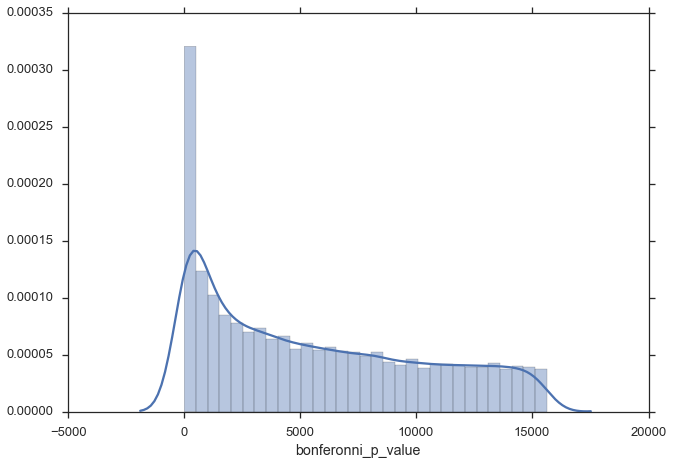

In [10]:
sns.distplot(kruskal_results_tidy.bonferonni_p_value)

In [11]:
p = 0.001
kruskal_results_tidy_significant = kruskal_results_tidy.ix[kruskal_results_tidy.bonferonni_p_value < p]
print kruskal_results_tidy_significant.gene_id.unique().shape
gene_ids = kruskal_results_tidy_significant.gene_id.unique()

(132,)


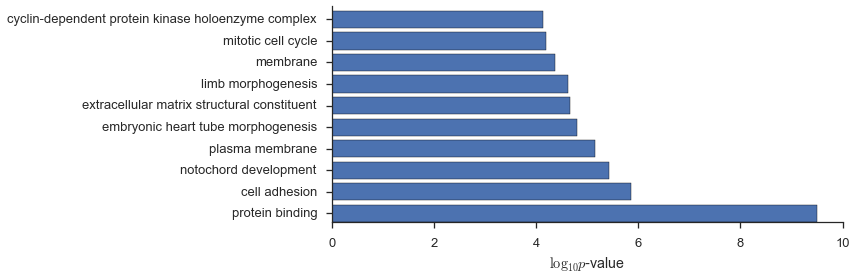

In [12]:
go = study.go_enrichment(gene_ids, background=expression.columns, p_value_cutoff=p)
go = go.iloc[:10, :]
sns.set(style='ticks', context='talk')

fig, ax = plt.subplots(figsize=(12, 4))

y = np.arange(go.shape[0])
width = -np.log10(go.bonferonni_corrected_p_value)
ax.barh(y, width)

yticks = y + 0.4
ax.set(yticklabels=go.go_name, yticks=yticks, xlabel='$\log_{10}p$-value', ylim=(0, y.max()+1))
sns.despine()
fig.tight_layout()
fig.savefig('{}/outlier_neural_types_go_enrichment.pdf'.format(folder))

#### Clustermap of DE genes

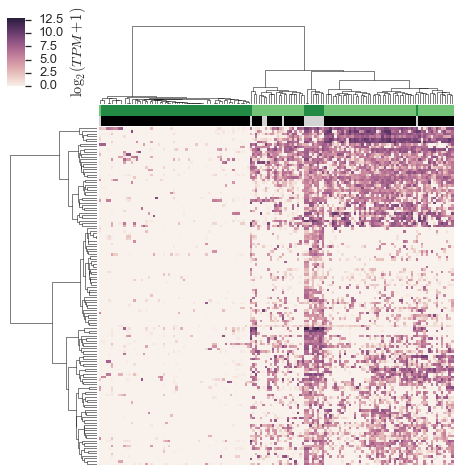

In [13]:
# data = expression.T
# data = (data - data.mean())/data.std()
# data = data.ix[gene_ids, :]
data = expression.ix[:, gene_ids].T

col_colors = [study.sample_id_to_color[data.columns], 
              study.metadata.data.outlier[data.columns].map(lambda x: 'lightgrey' if x else 'k')]
yticklabels = study.expression.feature_data.gene_name[data.index]

g = sns.clustermap(data=data, col_colors=col_colors, yticklabels=yticklabels, method='ward', figsize=(8, 8),
                  cbar_kws=dict(label='$\log_2(TPM+1)$'))
g.ax_heatmap.set(yticks=[], xticks=[])
g.ax_col_colors.set(xticks=[], yticks=[])
g.savefig('{}/outlier_neural_types_clustermap.pdf'.format(folder))

#### Colorbar legend

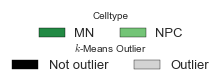

In [14]:
sns.set(style='ticks', context='talk')
fig, axes = plt.subplots(nrows=2, figsize=(2, 1))

phantom_bars = {'Celltype': {'NPC': study.phenotype_to_color['NPC'],
                             'MN': study.phenotype_to_color['MN']},
                '$k$-Means Outlier': {'Outlier': 'lightgrey', 'Not outlier': 'k'}}
legends = []
for (title, label_to_color), ax in zip(phantom_bars.items(), axes.flat):
    for label, color in label_to_color.items():
        ax.bar(0, 0, 0,  color=color, label=label)
    legends.append(ax.legend(loc='center', title=title, ncol=2))
    ax.axis('off')
fig.tight_layout()
fig.savefig('{}/outlier_neural_types_clustermap_color_labels.pdf'.format(folder), bbox_inches='tight', bbox_extra_artists=legends)


## Splicing quality control

In [15]:
sns.set(style='ticks', context='talk')

grouped = study.splicing.data_original.groupby(study.metadata.data.pooled)
detected_events = grouped.apply(lambda x: x.groupby(study.sample_id_to_phenotype).apply(lambda y: y.count(axis=1))).reset_index()
detected_events = detected_events.rename(columns={0: 'n_events', 'level_1': 'phenotype', 'level_2': 'sample_id'})
detected_events.head()

pooled phenotype sample_id  n_events
0  False        MN     M1_01     12314
1  False        MN     M1_02     17516
2  False        MN     M1_03     19467
3  False        MN     M1_04     16170
4  False        MN     M1_05      8833

In [16]:
detected_events.phenotype = pd.Categorical(detected_events.phenotype, categories=study.phenotype_order, ordered=True)

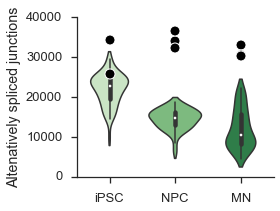

In [17]:
detected_events_singles = detected_events.ix[~detected_events.pooled]
detected_events_pooled = detected_events.ix[detected_events.pooled]


fig, ax = plt.subplots(figsize=(4, 3))
sns.violinplot(x='phenotype', y='n_events', data=detected_events_singles, palette=study.phenotype_color_ordered,
              cut=True, linewidth=1.5)
sns.stripplot(x='phenotype', y='n_events', data=detected_events_pooled, color='k', size=10)
sns.despine()
ax.set_xlabel('')
ax.set_ylabel('Altenatively spliced junctions')
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
ax.locator_params('y', nbins=5)
fig.tight_layout()
fig.savefig("/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_splicing/A_splicing_events_detected.pdf")

iPSC n_events.mean(), n_events.std() 20791.9076923 6762.47416752
NPC n_events.mean(), n_events.std() 14768.0 5269.50494069
MN n_events.mean(), n_events.std() 12082.7123288 6733.20389001


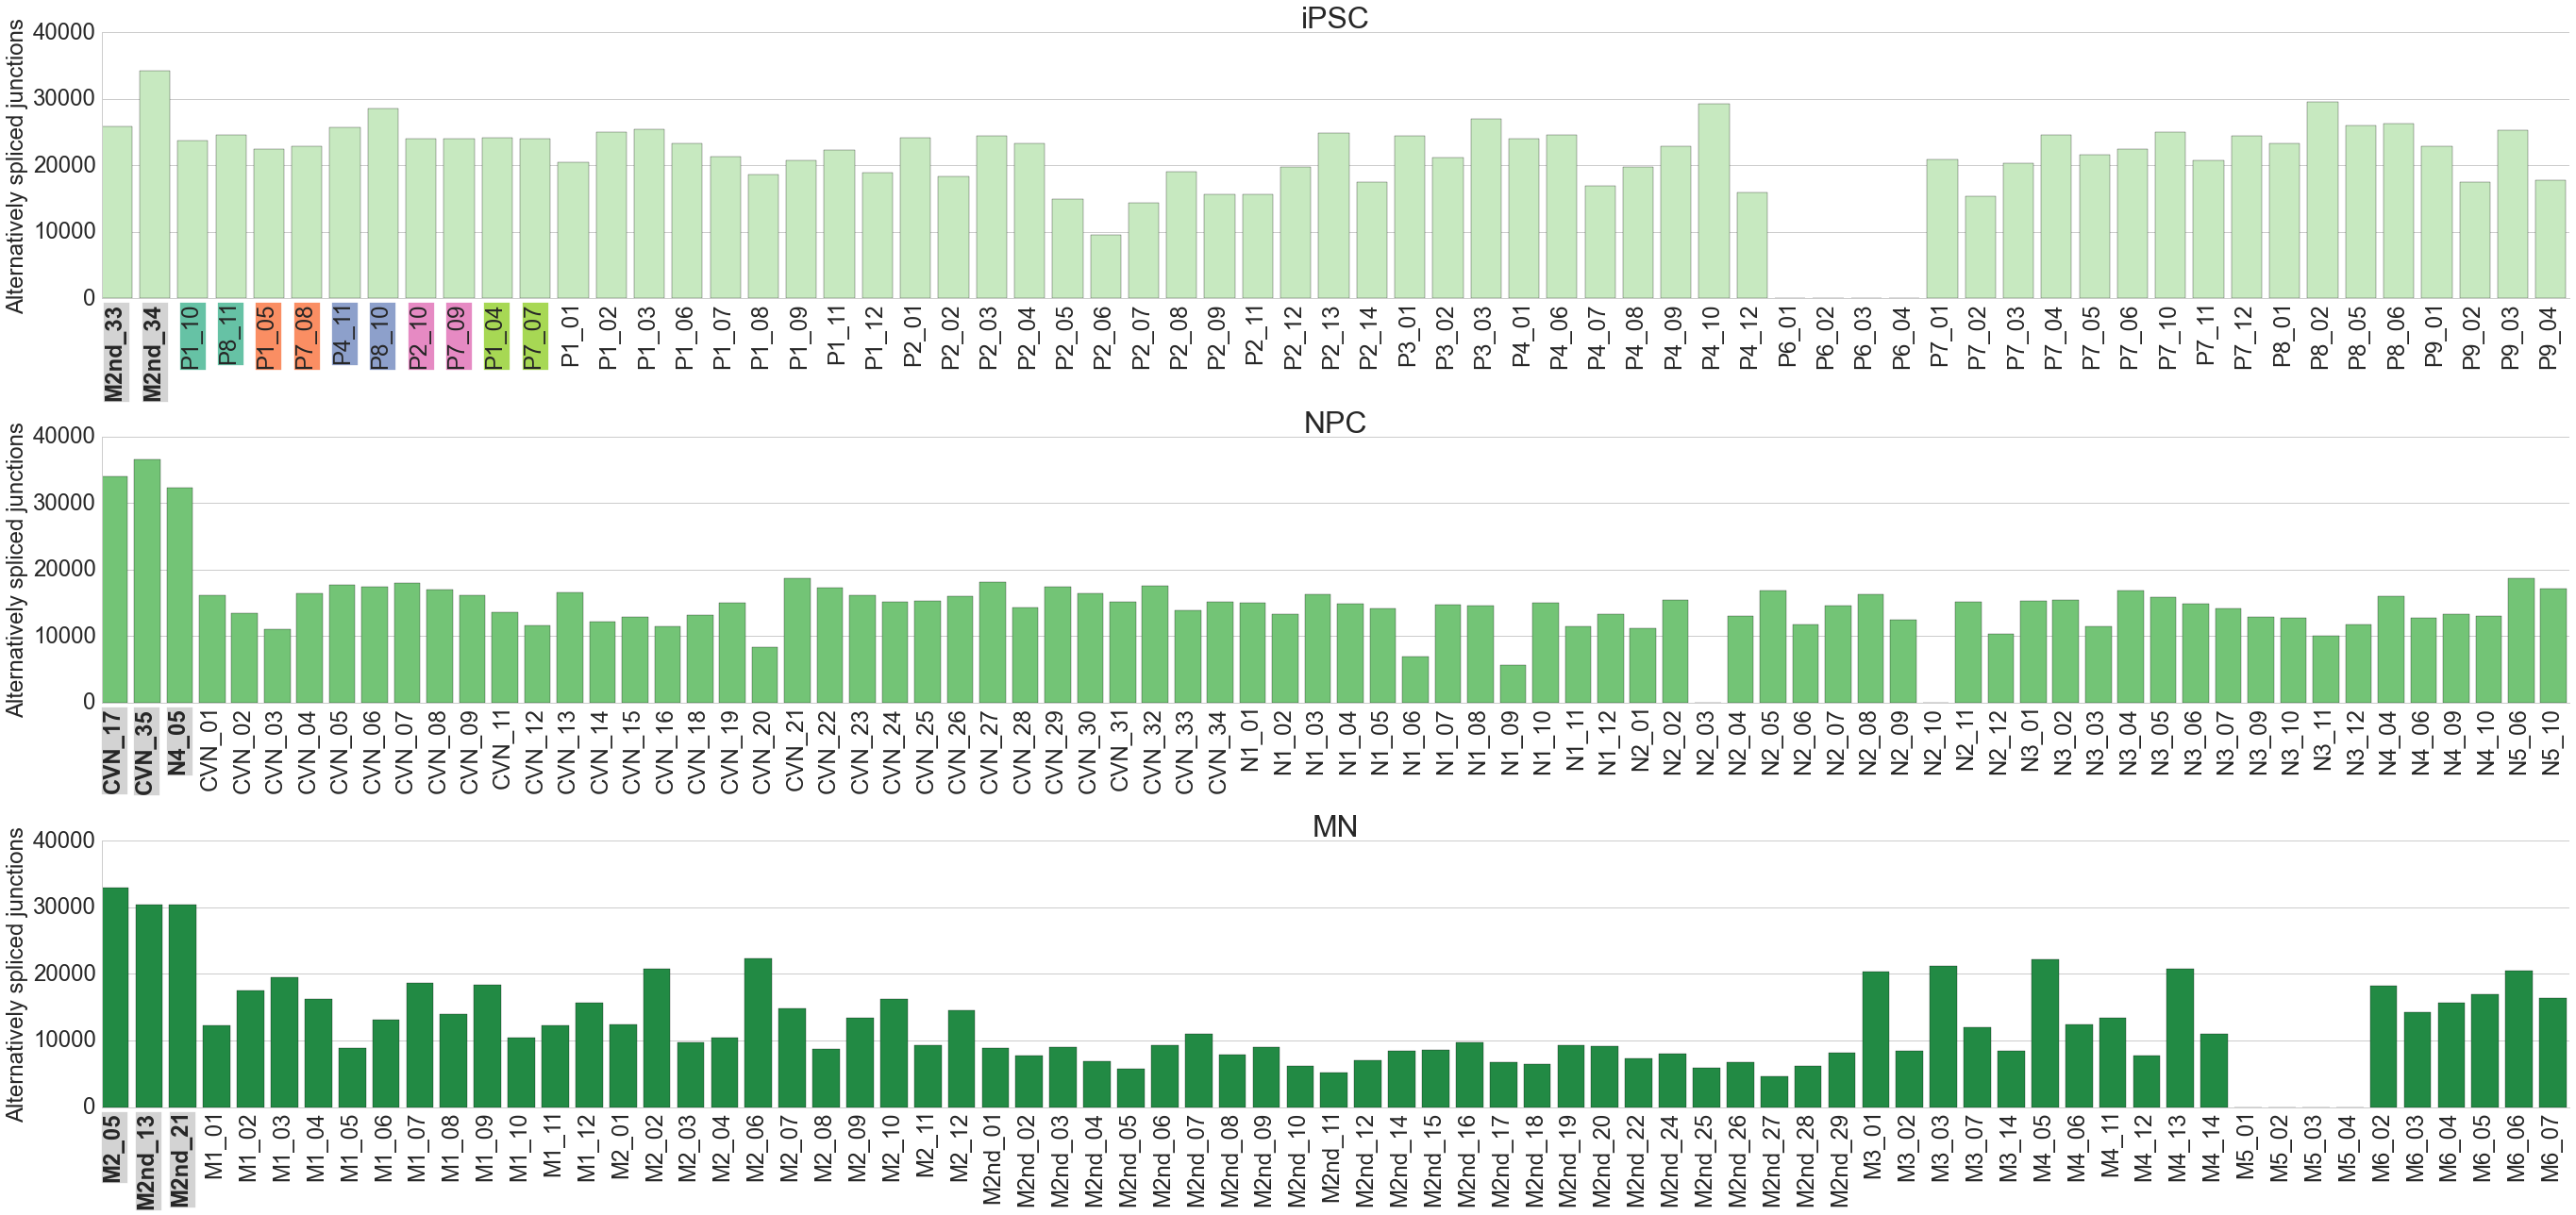

In [18]:
import itertools

sns.set(style='whitegrid')

nrows = study.metadata.n_phenotypes

largest_group = study.sample_id_to_phenotype.groupby(study.sample_id_to_phenotype).size().max()

fig, axes = plt.subplots(nrows=nrows, figsize=(.5*largest_group, 6*study.metadata.n_phenotypes), sharey=True)
paired = sns.color_palette('Paired', n_colors=4)

splits = study.metadata.data.split.dropna()
split_to_pair = dict((x, tuple(sorted([x, y]))) for x, y in splits.iteritems())
unique_pairs = set([tuple(sorted([x, y])) for x, y in splits.iteritems()])
pair_colors = sns.color_palette('Set2', n_colors=len(unique_pairs))
pair_to_colors = dict(zip(unique_pairs, pair_colors))


total_width = 0.8
# width = total_width/expression_binned.shape[1]


for ax, phenotype in zip(axes, study.metadata.phenotype_order):
    sample_ids = study.sample_id_to_phenotype.index[study.sample_id_to_phenotype == phenotype]
    pooled = sample_ids[study.metadata.data.pooled[sample_ids]]
    if phenotype == 'iPSC':
        split = list(itertools.chain(*unique_pairs))
    else:
        split = []
    singles = sample_ids.difference(pooled).difference(split)
    
    ordered_sample_ids = np.concatenate([pooled, split, singles])
    
    splicing = study.splicing.data_original.ix[ordered_sample_ids]
    n_events = splicing.T.count()
    print phenotype, 'n_events.mean(), n_events.std()', n_events.mean(), n_events.std()
    
    n_events = n_events.fillna(0)
    left = np.arange(n_events.shape[0])
    
    color = study.phenotype_to_color[phenotype]
    ax.bar(left, n_events, color=color, label='Number of splicing events detected' , width=total_width)
#     ax.set_ylim(1, n_events.max().max()*1.1)
    xticks = left+total_width/2
    ax.set_xticks(xticks)
    ax.set_xticklabels(ordered_sample_ids, rotation=90, visible=True, fontsize=24)
    ax.set_xlim(0, xticks.max()+0.5)
    
    for label in ax.get_xticklabels():
        text = label.get_text()
        if label.get_text() in study.pooled:
            label.set(backgroundcolor='lightgrey', weight='bold')
        elif text in splits:
            pair = split_to_pair[text]
            color = pair_to_colors[pair]
            label.set(backgroundcolor=color)
    ax.xaxis.grid(False)

    ax.set_title(phenotype, fontsize=32)
    ax.set_ylabel('Alternatively spliced junctions', fontsize=24)
    
#     ax.set_yticks(np.arange(0, n_events.max()+1000, 2500))
    ax.locator_params('y', nbins=5)
    for label in ax.get_yticklabels():
        label.set(size=24)
#     if ax.is_first_row():
#         ax.legend(loc="best", fontsize=24)
    
sns.despine()
fig.tight_layout()
fig.savefig('{}/quality_control_all_cells_splicing_barplots.pdf'.format(folder))

### Number of cells per event

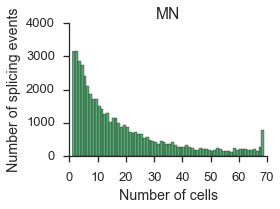

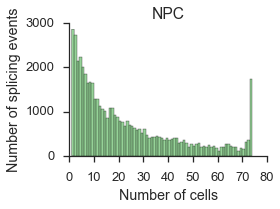

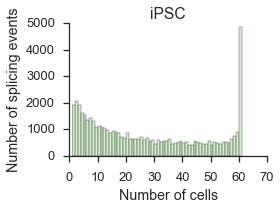

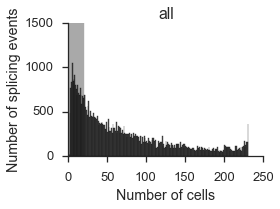

In [19]:
sns.set(style='ticks', context='talk')

for phenotype, df in study.splicing.data_original.groupby(study.sample_id_to_phenotype):    
    counts = df.count()
    fig, ax = plt.subplots(figsize=(4, 3))
    color = study.phenotype_to_color[phenotype]
    sns.distplot(counts, bins=np.arange(1, counts.max()+1), kde=False, color=color, hist_kws=dict(alpha=0.75))

    # Reduce nubmer of ticks
    ax.locator_params(axis='y', nbins=5)
    ax.set_title(phenotype)
    ax.set_xlabel('Number of cells')
    ax.set_ylabel('Number of splicing events')
    fig.tight_layout()
    sns.despine()
    fig.savefig('{}/n_cells_per_event_{}.pdf'.format(folder, phenotype))

    
## All events
phenotype = 'all'
counts = study.splicing.data_original.count()
fig, ax = plt.subplots(figsize=(4, 3))
color = '#262626'
sns.distplot(counts, bins=np.arange(1, counts.max()+1), kde=False, color=color, hist_kws=dict(alpha=0.75))
ymin, ymax = ax.get_ylim()
ax.set_title(phenotype)
ax.set_xlabel('Number of cells')
ax.set_ylabel('Number of splicing events')

# Reduce number of tick
ax.locator_params(axis='y', nbins=5)

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
x1 = [0, 0]
x2 = [20, 20]
# x1 = [20, 20]
# x2 = [xmax, xmax]

ax.fill_betweenx([ymin, ymax], x1, x2, color='darkgrey', zorder=-1)
fig.tight_layout()
sns.despine()
fig.savefig('{}/n_cells_per_event_{}.pdf'.format(folder, phenotype))


### Diversity of splice junction features
https://en.wikipedia.org/wiki/Diversity_index

#### True diversity

$^qD = \frac{1}{M_{q-1}} = \frac{1}{\sqrt[q-1]{\sum_{i=1}^{R} p_i p_i^{q-1}}} = \left(\sum_{i=1}^{R} p_i^q\right)^{1/(1-q)}$

* $M_{q-1}$: average proportional abundance of the types in the dataset
* $R$: richness
* $p_i$: Proportional abundance of the $i$th type

Pick different values of $q$...

With $q=1$, equation is undefined but limit approaches

$
^1D = \frac{1}{\prod_{i=1}^{R} p_i^{p_i}} = \exp\left(-\sum_{i=1}^{R}p_i \ln(p_i)\right)
$

In [20]:
splicing_original = study.splicing.data_original.copy()
singles = splicing_original.loc[study.splicing.singles.index]
print singles.shape
singles.head()

(225, 53192)


exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-  \
CVN_01                                                NaN                                                    
CVN_02                                                NaN                                                    
CVN_03                                                NaN                                                    
CVN_04                                                NaN                                                    
CVN_05                                                NaN                                                    

        exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-  \
CVN_01                                                NaN                                                    
CVN_02                                                NaN                                                    
CVN_03                                                NaN                                                    
CVN_04                                                NaN                                                    
CVN_05                                                NaN                                                    

        exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-  \
CVN_01                                                NaN                                                    
CVN_02                                                NaN                                                    
CVN_03                                                NaN                                                    
CVN_04                                                NaN                                                    
CVN_05                                                NaN                                                    

        exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-  \
CVN_01                                                NaN                                                    
CVN_02                                                NaN                                                    
CVN_03                                                NaN                                                    
CVN_04                                                NaN                                                    
CVN_05                                                NaN                                                    

        exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-  \
CVN_01                                                NaN                                                    
CVN_02                                                NaN                                                    
CVN_03                                                NaN                                                    
CVN_04                                                NaN                                                    
CVN_05                                                NaN                                                    

        exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193740-100193848:-  \
CVN_01                                                NaN                                                    
CVN_02                                                NaN                                                    
CVN_03                                                NaN                                                    
CVN_04                                                NaN                                                    
CVN_05                                                NaN                                                    

        exon:chr10:101165513-101165617:-@e

In [21]:
counts = splicing_original.groupby(study.sample_id_to_phenotype).count()
proportions = counts.divide(counts.sum(axis=1), axis='index')
proportions.head()

exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-  \
phenotype                                                                                                       
MN                                                  0.000001                                                    
NPC                                                 0.000002                                                    
iPSC                                                0.000016                                                    

           exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-  \
phenotype                                                                                                       
MN                                                  0.000001                                                    
NPC                                                 0.000002                                                    
iPSC                                                0.000016                                                    

           exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-  \
phenotype                                                                                                       
MN                                                  0.000001                                                    
NPC                                                 0.000002                                                    
iPSC                                                0.000016                                                    

           exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-  \
phenotype                                                                                                       
MN                                              1.133738e-06                                                    
NPC                                             8.909734e-07                                                    
iPSC                                            1.479866e-05                                                    

           exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-  \
phenotype                                                                                                       
MN                                                  0.000003                                                    
NPC                                                 0.000002                                                    
iPSC                                                0.000013                                                    

           exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193740-100193848:-  \
phenotype                                                                                                       
MN                                                  0.000003                                                    
NPC                                                 0.000002                                                    
iPSC                                                0.000013                                                    

           exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-  \
phenotype                                                                                                       
MN                                                  0.000026                                                    
NPC                                                 0.000023                                                    
iPSC                                                0.000024                                                    

           exon:chr10:101419263-101419345:+@exon:

Implementation of:

$
^1D = \frac{1}{\prod_{i=1}^{R} p_i^{p_i}} = \exp\left(-\sum_{i=1}^{R}p_i \ln(p_i)\right)
$

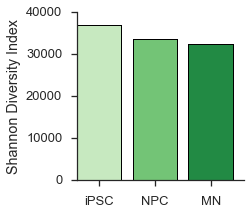

In [22]:
sns.set(style='ticks', context='talk')
diversity = np.exp(- proportions.multiply(np.log(proportions)).sum(axis=1))
diversity = diversity[study.phenotype_order]

fig, ax = plt.subplots(figsize=(3, 3))
left = np.arange(diversity.shape[0])
color = [study.phenotype_to_color[p] for p in diversity.index]
ax.bar(left, diversity, color=color, linewidth=1)

xticks = left + 0.4
ax.locator_params('y', nbins=4)
ax.set(xticks=xticks, xticklabels=diversity.index, ylabel='Shannon Diversity Index')
sns.despine()

### Inverse Simpson index

This is more intuitive because datasets with a larger number of species and fewer abundances per species will have larger diversity.

$1/\lambda = \frac{1}{\sum_{i=1}^R p_i^2} =\, ^2D$

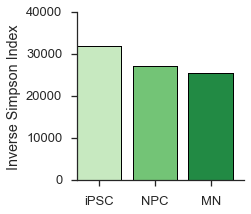

In [23]:
sns.set(style='ticks', context='talk')
diversity = 1/np.square(proportions).sum(axis=1)
diversity = diversity[study.phenotype_order]

fig, ax = plt.subplots(figsize=(3, 3))
left = np.arange(diversity.shape[0])
color = [study.phenotype_to_color[p] for p in diversity.index]
ax.bar(left, diversity, color=color, linewidth=1)

xticks = left + 0.4
ax.locator_params('y', nbins=4)
ax.set(xticks=xticks, xticklabels=diversity.index, ylabel='Inverse Simpson Index')
sns.despine()

### Percentage of events detected in only one cell

In [24]:
junction_counts = splicing_original.groupby(study.sample_id_to_phenotype).count().unstack()
junction_counts.head()

                                                                                                    phenotype
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-  MN            1
                                                                                                    NPC           2
                                                                                                    iPSC         21
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-  MN            1
                                                                                                    NPC           2
dtype: int64

In [25]:
junction_counts = junction_counts.reset_index()
junction_counts = junction_counts.rename(columns={'level_0': 'event_name', 0: 'n_cells'})
junction_counts.head()

event_name phenotype  n_cells
0  exon:chr10:100190328-100190427:-@exon:chr10:10...        MN        1
1  exon:chr10:100190328-100190427:-@exon:chr10:10...       NPC        2
2  exon:chr10:100190328-100190427:-@exon:chr10:10...      iPSC       21
3  exon:chr10:100190328-100190427:-@exon:chr10:10...        MN        1
4  exon:chr10:100190328-100190427:-@exon:chr10:10...       NPC        2

In [26]:
print junction_counts.shape
junction_counts = junction_counts.loc[junction_counts.n_cells > 0]
print junction_counts.shape

(159576, 3)
(150410, 3)


In [28]:

   
def percent_junctions_at_quantiles(series, quantiles=[0, 0.25, 0.5, 1.]):
    """Get the percent of junctions observed in 25% of cells, 50% of cells, etc
    
    Note: 0% gets interpreted as how many junctions were observed in 1 cell, not 0 cells 
    (since 0 cells is boring)
    """
    series.index = series.index.droplevel(0)
    total = series.sum()
    percentage = 100*series/total
    
    percentage_at_quantiles = pd.Series(index=quantiles)
    for q in quantiles:
        if q == 0:
            percentage_at_quantiles.loc[0] = percentage[1]
        else:
            i = int(np.round(q * series.index.max()))
#             print q, i, series[:i]/total
            percentage_at_quantiles.loc[q] = percentage[i]
    return percentage_at_quantiles

In [32]:
junctions_per_cell = junction_counts.groupby(['phenotype', 'n_cells']).size()
percent_junctions_per_cell = junctions_per_cell/junctions_per_cell.groupby(level=0).sum()
# percent_junctions_per_cell = percent_junctions_per_cell.unstack()
# percent_junctions_per_cell.columns = percent_junctions_per_cell.columns + 1
percent_junctions_per_cell.head()

phenotype  n_cells
MN         1          0.063590
           2          0.063892
           3          0.057906
           4          0.055004
           5          0.048554
dtype: float64

In [33]:
percentage_junctions_quantiles = junctions_per_cell.groupby(level=0).apply(percent_junctions_at_quantiles).reset_index()
percentage_junctions_quantiles = percentage_junctions_quantiles.rename(
    columns={'level_1': 'Quantity of cells', 0:'Percentage of junctions'})
percentage_junctions_quantiles['Quantity of cells'] *= 100
percentage_junctions_quantiles['Quantity of cells'] = percentage_junctions_quantiles['Quantity of cells'].replace(0, '1 cell')
percentage_junctions_quantiles['Quantity of cells'] = percentage_junctions_quantiles['Quantity of cells'].map(
    lambda x: x if isinstance(x, str) else '{:.0f}%'.format(x))
percentage_junctions_quantiles.head()

phenotype Quantity of cells  Percentage of junctions
0        MN            1 cell                 6.358964
1        MN               25%                 2.009473
2        MN               50%                 0.721556
3        MN              100%                 1.076287
4       NPC            1 cell                 5.684796

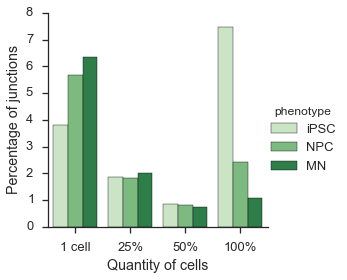

In [34]:
g = sns.factorplot(x='Quantity of cells', y='Percentage of junctions', data=percentage_junctions_quantiles, 
               hue='phenotype', kind='bar', hue_order=study.phenotype_order,
              palette=study.phenotype_color_ordered)
g.savefig('{}/quantity_of_cells_per_percentage_of_junctions_barplot.pdf'.format(folder))

## PCA

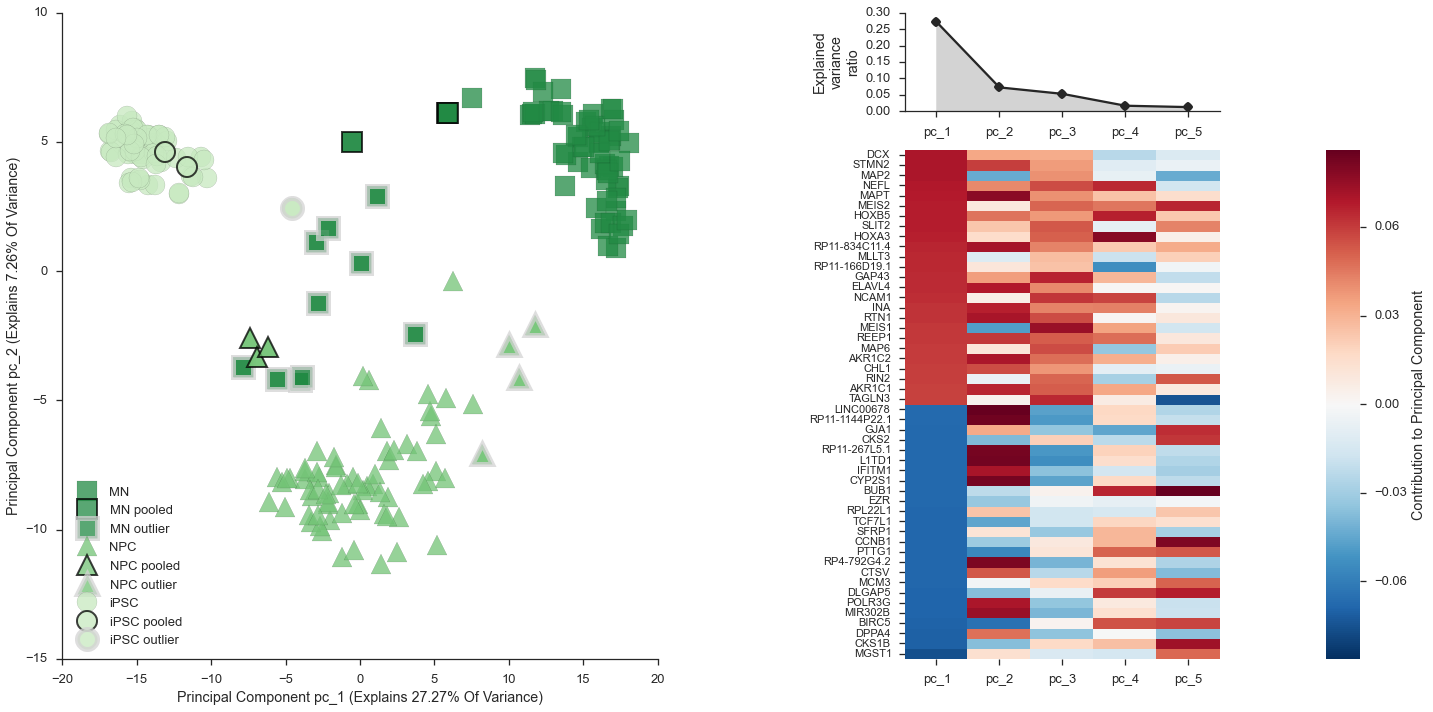

In [36]:
viz = study.plot_pca(show_vectors=False, scale_by_variance=False, markersize=20)
viz.fig_reduced.savefig('{}/pca_variant.pdf'.format(folder))

## Only use splicing events detected in at least 20 samples in at least 1 celltype

In [38]:
alternative = study.splicing.data_original.groupby(study.sample_id_to_phenotype).apply(lambda x: x.dropna(thresh=20, axis=1))
print study.splicing.data_original.shape, alternative.shape
# constitutive = study.supplemental.psi_constitutive.groupby(study.sample_id_to_phenotype).apply(lambda x: x.dropna(thresh=20, axis=1))
# print study.supplemental.psi_constitutive.shape, constitutive.shape

(233, 53192) (233, 29389)


In [39]:
study.splicing.data_original = alternative
# study.supplemental.psi_constitutive = constitutive

### Distribution of gene expression for all genes, and genes for which we measured splicing

In [41]:
splicing_metadata = pd.read_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/skipped_exon_metadata.csv', index_col=0)
study.splicing.feature_expression_id_col = 'one_ensembl_id'
study.splicing.feature_data = splicing_metadata
cols = study.expression.feature_data.columns.difference(study.splicing.feature_data.columns)
study.splicing.feature_data = study.splicing.feature_data.join(study.expression.feature_data[cols], on='one_ensembl_id')

study.splicing.feature_data.head()

gencode_id  \
event_id                                                                 
exon:chr10:100190328-100190427:-@exon:chr10:100...  ENSG00000107521.14   
exon:chr10:100190328-100190427:-@exon:chr10:100...  ENSG00000107521.14   
exon:chr10:100190328-100190427:-@exon:chr10:100...  ENSG00000107521.14   
exon:chr10:100193697-100193848:-@exon:chr10:100...  ENSG00000107521.14   
exon:chr10:100195392-100195529:-@exon:chr10:100...  ENSG00000107521.14   

                                                         ensembl_id gene_name  \
event_id                                                                        
exon:chr10:100190328-100190427:-@exon:chr10:100...  ENSG00000107521      HPS1   
exon:chr10:100190328-100190427:-@exon:chr10:100...  ENSG00000107521      HPS1   
exon:chr10:100190328-100190427:-@exon:chr10:100...  ENSG00000107521      HPS1   
exon:chr10:100193697-100193848:-@exon:chr10:100...  ENSG00000107521      HPS1   
exon:chr10:100195392-100195529:-@exon:chr10:100...  ENSG00000107521      HPS1   

                                                    exon1_length  \
event_id                                                           
exon:chr10:100190328-100190427:-@exon:chr10:100...           100   
exon:chr10:100190328-100190427:-@exon:chr10:100...           100   
exon:chr10:100190328-100190427:-@exon:chr10:100...           100   
exon:chr10:100193697-100193848:-@exon:chr10:100...           152   
exon:chr10:100195392-100195529:-@exon:chr10:100...           138   

                                                    exon2_length  \
event_id                                                           
exon:chr10:100190328-100190427:-@exon:chr10:100...            99   
exon:chr10:100190328-100190427:-@exon:chr10:100...            99   
exon:chr10:100190328-100190427:-@exon:chr10:100...            99   
exon:chr10:100193697-100193848:-@exon:chr10:100...           161   
exon:chr10:100195392-100195529:-@exon:chr10:100...           143   

                                                    exon3_length  \
event_id                                                           
exon:chr10:100190328-100190427:-@exon:chr10:100...           492   
exon:chr10:100190328-100190427:-@exon:chr10:100...           487   
exon:chr10:100190328-100190427:-@exon:chr10:100...            70   
exon:chr10:100193697-100193848:-@exon:chr10:100...           100   
exon:chr10:100195392-100195529:-@exon:chr10:100...           152   

                                                    intron1_length  \
event_id                                                             
exon:chr10:100190328-100190427:-@exon:chr10:100...             681   
exon:chr10:100190328-100190427:-@exon:chr10:100...             681   
exon:chr10:100190328-100190427:-@exon:chr10:100...             681   
exon:chr10:100193697-100193848:-@exon:chr10:100...            2648   
exon:chr10:100195392-100195529:-@exon:chr10:100...             220   

                                                    intron2_length  \
event_id                                                             
exon:chr10:100190328-100190427:-@exon:chr10:100...             148   
exon:chr10:100190328-100190427:-@exon:chr10:100...             148   
exon:chr10:100190328-100190427:-@exon:chr10:100...             148   
exon:chr10:100193697-100193848:-@exon:chr10:100...             460   
exon:chr10:100195392-100195529:-@exon:chr10:100...            1180   

                                                   exon2_divisible_by_3  \
event_id                                                                  
exon:chr10:100190328-100190427:-@exon:chr10:100...                 True   
exon:chr10:100190328-100190427:-@exon:chr10:100...                 True   
exon:chr10:100190328-100190427:-@exon:chr10:100...                 True   
exon:chr10:100193697-100193848:-@exon:chr10:100...                False   
exon:chr10:100195392-100195529:-@exon:chr10:100...                False   

                                  

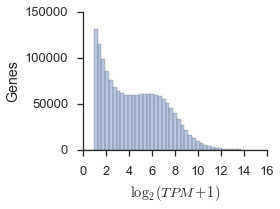

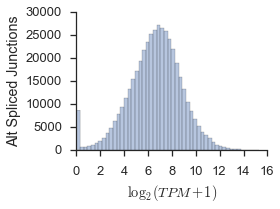

In [43]:
## Genes
fig, ax = plt.subplots(figsize=(4, 3))
sns.distplot(study.expression.data[study.expression.data >= 1].values.flat, kde=False,
            bins=np.linspace(0, 16, 50), ax=ax)
ax.set_ylabel('Genes')
ax.set_xlabel('$\log_2(TPM+1)$')
ax.locator_params(axis='y', nbins=6)
sns.despine()
fig.tight_layout()
fig.savefig('/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_splicing_supplementary/distribution_of_expression_all_genes.pdf')



## Splicing events
fig, ax = plt.subplots(figsize=(4, 3))
no_duplicate_genes = study.tidy_splicing_with_expression.groupby(['sample_id', 'common_id']).expression.mean()
sns.distplot(np.log2(no_duplicate_genes+1), kde=False, ax=ax)
ax.locator_params(axis='y', nbins=6)
ax.set_ylabel('Alt Spliced Junctions')
ax.set_xlabel('$\log_2(TPM+1)$')
sns.despine()
fig.tight_layout()
fig.savefig('/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_splicing_supplementary/distribution_of_expression_of_splicing_events.pdf')

### Only use splicing events with mean gene expression TPM > 1

In [45]:
grouped = study.tidy_splicing_with_expression.groupby(['sample_id', 'event_name'], as_index=False)
# Take the mean psi if there are multiple splicing events per gene, for each sample's splicing event
summed_expression = grouped.agg({'expression':'mean', 'psi': 'mean'})
splicing_tidy_filtered = summed_expression.ix[summed_expression.expression >= 1]
splicing_filtered = splicing_tidy_filtered.pivot(index='sample_id', columns='event_name', values='psi')
print splicing_filtered.shape
splicing_filtered.head()

(204, 37542)


event_name  exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-  \
sample_id                                                                                                        
CVN_01                                                    NaN                                                    
CVN_02                                                    NaN                                                    
CVN_03                                                    NaN                                                    
CVN_04                                                    NaN                                                    
CVN_05                                                    NaN                                                    

event_name  exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-  \
sample_id                                                                                                        
CVN_01                                                    NaN                                                    
CVN_02                                                    NaN                                                    
CVN_03                                                    NaN                                                    
CVN_04                                                    NaN                                                    
CVN_05                                                    NaN                                                    

event_name  exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-  \
sample_id                                                                                                        
CVN_01                                                    NaN                                                    
CVN_02                                                    NaN                                                    
CVN_03                                                    NaN                                                    
CVN_04                                                    NaN                                                    
CVN_05                                                    NaN                                                    

event_name  exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-  \
sample_id                                                                                                        
CVN_01                                                    NaN                                                    
CVN_02                                                    NaN                                                    
CVN_03                                                    NaN                                                    
CVN_04                                                    NaN                                                    
CVN_05                                                    NaN                                                    

event_name  exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-  \
sample_id                                                                                                        
CVN_01                                                    NaN                                                    
CVN_02                                                    NaN                                                    
CVN_03                                                    NaN                                                    
CVN_04                                                    NaN                                                    
CVN_05                                                    NaN                                                    

event

In [46]:
splicing_filter_check = splicing_tidy_filtered.merge(study.tidy_splicing_with_expression, left_on=['sample_id', 'event_name'],
                            right_on=['sample_id', 'event_name'])
splicing_filter_check.head()

sample_id                                         event_name  psi_x  \
0    CVN_01  exon:chr10:101165513-101165617:-@exon:chr10:10...      1   
1    CVN_01  exon:chr10:101507014-101507147:+@exon:chr10:10...      1   
2    CVN_01  exon:chr10:101507014-101507147:+@exon:chr10:10...      1   
3    CVN_01  exon:chr10:101507014-101507147:+@exon:chr10:10...      1   
4    CVN_01  exon:chr10:101507014-101507147:+@exon:chr10:10...      1   

   expression_x  psi_y        common_id  expression_y  
0     104.96955      1  ENSG00000120053     104.96955  
1     132.06900      1  ENSG00000119929     132.06900  
2     132.06900      1  ENSG00000119929     132.06900  
3     132.06900      1  ENSG00000119929     132.06900  
4     132.06900      1  ENSG00000119929     132.06900

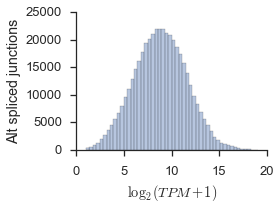

In [47]:
## Splicing events
fig, ax = plt.subplots(figsize=(4, 3))
# ind = study.tidy_splicing_with_expression['event_name'].isin(splicing_filtered.columns)
# tidy_splicing_with_expression_filtered = study.tidy_splicing_with_expression.ix[ind]
no_duplicate_genes = splicing_filter_check.groupby(['sample_id', 'common_id']).expression_x.sum()

sns.distplot(np.log2(no_duplicate_genes+1), kde=False)
ax.locator_params(axis='y', nbins=5)
ax.set_ylabel('Alt spliced junctions')
ax.set_xlabel('$\log_2(TPM+1)$')
sns.despine()
fig.tight_layout()

Assign this new splicing matrix to our `study`.

In [48]:
print study.splicing.data_original.shape
study.splicing.data_original = splicing_filtered
study.splicing.data = splicing_filtered
print study.splicing.data_original.shape

(233, 29389)
(204, 37542)


In [49]:
study.save('singlecell_pnm_figure1_supplementary_post_splicing_filtering')

Wrote datapackage to /home/obotvinnik/flotilla_projects/singlecell_pnm_figure1_supplementary_post_splicing_filtering/datapackage.json


In [50]:
study = flotilla.embark('singlecell_pnm_figure1_supplementary_post_splicing_filtering')

2015-09-24 17:29:49	Reading datapackage from /home/obotvinnik/flotilla_projects/singlecell_pnm_figure1_supplementary_post_splicing_filtering/datapackage.json
2015-09-24 17:29:49	Parsing datapackage to create a Study object
2015-09-24 17:30:43	Initializing Study
2015-09-24 17:30:43	Initializing Predictor configuration manager for Study
2015-09-24 17:30:43	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-09-24 17:30:43	Added ExtraTreesClassifier to default predictors
2015-09-24 17:30:43	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-09-24 17:30:43	Added ExtraTreesRegressor to default predictors
2015-09-24 17:30:43	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-09-24 17:30:43	Added GradientBoostingClassifier to default predictors
2015-09-24 17:30:43	Predictor GradientBoostingRegressor is of type <class 'skle

In [55]:
study.splicing.data.shape

(204, 35974)

In [56]:
study.splicing.data_original.shape

(204, 37542)

In [53]:
study.splicing.feature_expression_id_col = 'ensembl_id'

### Distribution of gene expression for all genes, and genes for which we measured splicing
After filtering for TPM>1

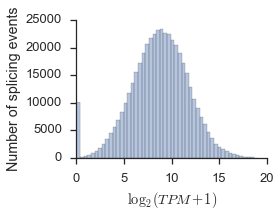

In [57]:
## Splicing events
fig, ax = plt.subplots(figsize=(4, 3))
# ind = study.tidy_splicing_with_expression['event_name'].isin(splicing_filtered.columns)
# tidy_splicing_with_expression_filtered = study.tidy_splicing_with_expression.ix[ind]
no_duplicate_genes = study.tidy_splicing_with_expression.groupby(['sample_id', 'common_id']).expression.sum()

sns.distplot(np.log2(no_duplicate_genes+1), kde=False)
ax.locator_params(axis='y', nbins=5)
ax.set_ylabel('Number of splicing events')
ax.set_xlabel('$\log_2(TPM+1)$')
sns.despine()
fig.tight_layout()
fig.savefig('/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_splicing_supplementary/distribution_of_expression_of_splicing_events.pdf')

### Venn diagram of shared events

/home/obotvinnik/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1353: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  "use .difference()",FutureWarning)


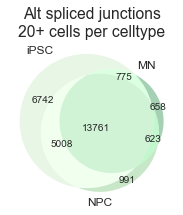

In [58]:
events_per_phenotype = dict((name, df.dropna(thresh=20, axis=1).dropna(how='all',axis=0).columns)
                            for name, df in study.splicing.data.groupby(study.sample_id_to_phenotype))
events_per_phenotype_count = pd.Series(events_per_phenotype).map(len)

phenotypes, events = zip(*events_per_phenotype.items())

fig, ax = plt.subplots(figsize=(4, 3))
matplotlib_venn.venn3(events, set_labels=phenotypes, 
                      set_colors=[study.phenotype_to_color[p] for p in phenotypes])
ax = plt.gca()
ax.set_title('Alt spliced junctions\n20+ cells per celltype')
fig = plt.gcf()
fig.tight_layout()
fig.savefig('/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_splicing/shared_events_venn_20_per_phenotype.pdf')

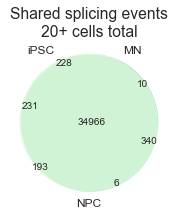

In [59]:
events_per_phenotype = dict((name, df.dropna(how='all',axis=1).dropna(how='all', axis=0).columns)
                            for name, df in study.splicing.data.groupby(study.sample_id_to_phenotype))
events_per_phenotype_count = pd.Series(events_per_phenotype).map(len)

phenotypes, events = zip(*events_per_phenotype.items())

fig, ax = plt.subplots(figsize=(4, 3))
matplotlib_venn.venn3(events, set_labels=phenotypes, 
                      set_colors=[study.phenotype_to_color[p] for p in phenotypes])
ax = plt.gca()
ax.set_title('Shared splicing events\n20+ cells total')
fig = plt.gcf()
fig.tight_layout()
fig.savefig('/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_splicing/shared_events_venn_20_total.pdf')

In [60]:
event_to_genes =  study.tidy_splicing_with_expression.drop(['sample_id', 'psi', 'expression'], axis=1)
event_to_genes = event_to_genes.drop_duplicates()
event_to_genes.head()

event_name        common_id
0  exon:chr10:100190328-100190427:-@exon:chr10:10...  ENSG00000107521
1  exon:chr10:100190328-100190427:-@exon:chr10:10...  ENSG00000107521
2  exon:chr10:100190328-100190427:-@exon:chr10:10...  ENSG00000107521
3  exon:chr10:100195392-100195529:-@exon:chr10:10...  ENSG00000107521
4  exon:chr10:100195392-100195529:-@exon:chr10:10...  ENSG00000107521

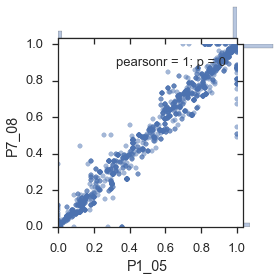

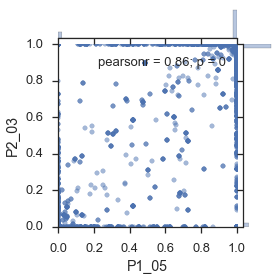

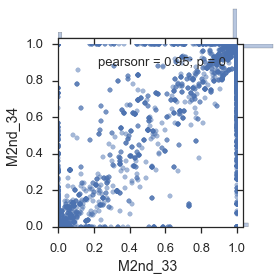

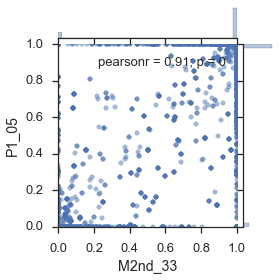

In [61]:
comparisons = [('P1_05', 'P7_08'),
               ('P1_05', 'P2_03'),
               ('M2nd_33', 'M2nd_34'),
               ('M2nd_33', 'P1_05')]
for sample1, sample2 in comparisons:
    study.plot_two_samples(sample1, sample2, 'splicing', size=4)

CPU times: user 3min 21s, sys: 1.72 s, total: 3min 23s
Wall time: 3min 24s


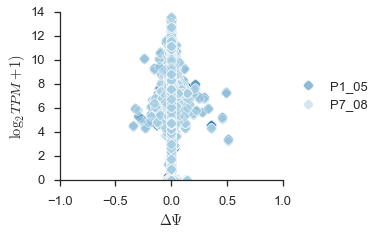

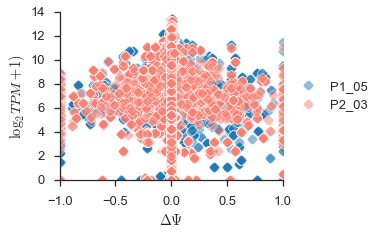

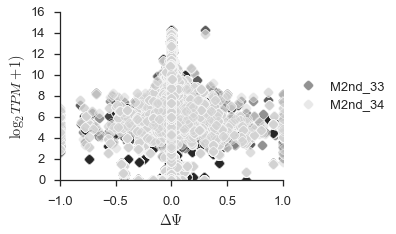

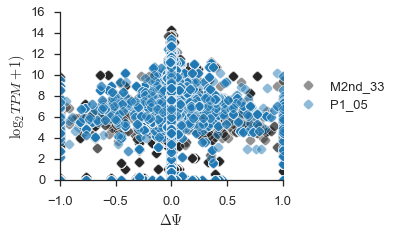

In [62]:
%%time

seen = set([])
tidy_splicing_with_expression = study.tidy_splicing_with_expression.copy()
tidy_splicing_with_expression = tidy_splicing_with_expression.set_index('event_name').sort_index()
dark2 = sns.color_palette('Dark2')

splits = study.metadata.data.split.dropna()

paired = sns.color_palette('Paired')

sample_colors = {'P1_05': paired[1],
                'P7_08': paired[0],
                'P2_03': 'salmon',
                'M2nd_33': '#262626',
                'M2nd_34': 'lightgrey'}


for sample1, sample2 in comparisons:
    fig, ax = plt.subplots(figsize=(4,3))
    
    ind1 = tidy_splicing_with_expression.sample_id == sample1
    ind2 = tidy_splicing_with_expression.sample_id == sample2
    
    psi1 = tidy_splicing_with_expression.ix[ind1, 'psi']
    psi2 = tidy_splicing_with_expression.ix[ind2, 'psi']
    delta_psi = (psi1 - psi2).dropna()

    for sample in (sample1, sample2):
        ind = tidy_splicing_with_expression.sample_id == sample
        y = np.log2(tidy_splicing_with_expression.ix[ind, 'expression']+1)
        x, y = delta_psi.align(y, 'inner')
        color = sample_colors[sample]
        ax.plot(x, y, 'o', label=sample, markerfacecolor=color, alpha=0.5, markeredgewidth=0.75, markeredgecolor='white',
               rasterized=True)
    legend = ax.legend(**{'bbox_to_anchor': (1, 0.5), 'loc': 'center left'})
    ax.set_xlabel('$\Delta \Psi$')
    ax.set_ylabel('$\\log_2{{TPM+1)}}$')
    ax.set_xlim(-1, 1)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax)
    sns.despine()
    fig.savefig('{}/split_delta_psi_vs_tpm_{}_{}.png'.format(folder, sample1, sample2), 
                format='png', dpi=300, **{'bbox_extra_artists': (legend,), 'bbox_inches': 'tight'})

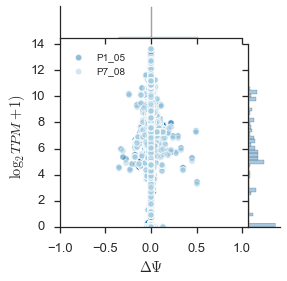

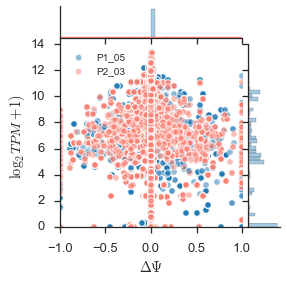

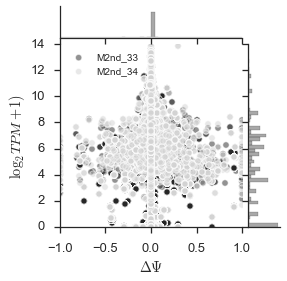

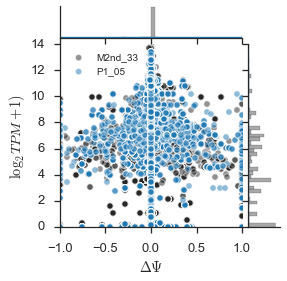

In [63]:
# sns.set(style='whitegrid')

tidy_splicing_with_expression = study.tidy_splicing_with_expression
tidy_splicing_with_expression = tidy_splicing_with_expression.set_index('event_name').sort_index()
dark2 = sns.color_palette('Dark2')

splits = study.metadata.data.split.dropna()

paired = sns.color_palette('Paired')

sample_colors = {'P1_05': paired[1],
                'P7_08': paired[0],
                'P2_03': 'salmon',
                'M2nd_33': '#262626',
                'M2nd_34': 'lightgrey'}

folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_splicing'

for sample1, sample2 in comparisons:
#     fig, ax = plt.subplots(figsize=(4,3))
    
    ind1 = tidy_splicing_with_expression.sample_id == sample1
    ind2 = tidy_splicing_with_expression.sample_id == sample2
    
    psi1 = tidy_splicing_with_expression.ix[ind1, 'psi']
    psi2 = tidy_splicing_with_expression.ix[ind2, 'psi']
    delta_psi = (psi1 - psi2).dropna()

    # Plot sample1 and set up the jointgrid
    ind = tidy_splicing_with_expression.sample_id == sample1
    y = np.log2(tidy_splicing_with_expression.ix[ind, 'expression']+1)
    x, y = delta_psi.align(y, 'inner')
    color = sample_colors[sample1]
    g = sns.jointplot(x, y, color=color, joint_kws=dict(alpha=0.5, linewidth=1, edgecolor='white', label=sample1, 
                                                        rasterized=True, s=40), 
                      xlim=(-1, 1), ylim=(0, 14), size=4,
                     stat_func=None)
    
    # Plot sample 2 using existing jointgrid
    ind = tidy_splicing_with_expression.sample_id == sample2
    y = np.log2(tidy_splicing_with_expression.ix[ind, 'expression']+1)
    x, y = delta_psi.align(y, 'inner')
    color = sample_colors[sample2] 
    g.x, g.y = x, y
    g.plot_joint(plt.scatter, color=color, alpha=0.5, label=sample2, linewidth=1, edgecolor='white', rasterized=True,
                s=40)
    g.plot_marginals(sns.distplot, color=color)
    g.ax_marg_x.set_xlabel('')
    g.ax_marg_y.set_ylabel('')

    g.ax_joint.legend(loc="upper left", fontsize=10)
#     legend = g.ax_joint.legend(**{'bbox_to_anchor': (1, 0.5), 'loc': 'center left'})
    g.ax_joint.set_xlabel('$\Delta \Psi$')
    g.ax_joint.set_ylabel('$\\log_2{{TPM+1)}}$')
#     ax.set_xlim(-1, 1)
#     ymin, ymax = ax.get_ylim()
#     ax.set_ylim(0, ymax)
    sns.despine()
    g.savefig('{}/split_delta_psi_vs_tpm_{}_{}.png'.format(folder, sample1, sample2), dpi=300)

## Venn diagrams of shared events

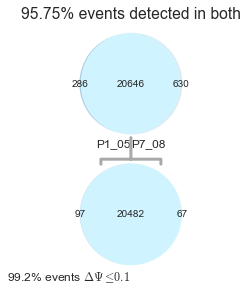

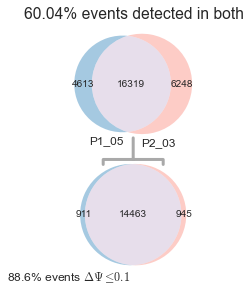

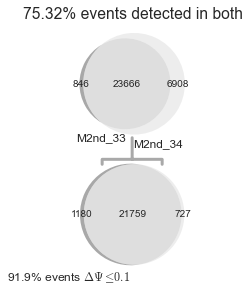

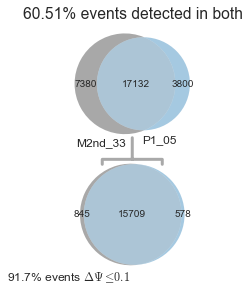

In [64]:
for sample1, sample2 in comparisons:
    color1 = sample_colors[sample1]
    color2 = sample_colors[sample2]
    
    psi1_original = study.splicing.data_original.ix[sample1].dropna()
    psi2_original = study.splicing.data_original.ix[sample2].dropna()
    
    union = psi1_original.index.union(psi2_original.index)
    both = psi1_original.index.intersection(psi2_original.index)
    percent_in_both = 100.*both.shape[0]/float(union.shape[0])
    
    fig, axes = plt.subplots(figsize=(4, 4), nrows=2)
    ax = axes[0]
    matplotlib_venn.venn2([psi1_original.index, psi2_original.index], set_labels=(sample1, sample2),
                          set_colors=(color1, color2), ax=ax)
    ax.set_title('{:.2f}% events detected in both'.format(percent_in_both))
    
    psi1, psi2 = psi1_original.align(psi2_original, 'inner')
    diff = psi1-psi2
    venn_data = {'11': diff[diff.abs() <= 0.1].shape[0], 
                 '10': diff[diff > 0.1].shape[0], 
                 '01': diff[diff < -0.1].shape[0]} 
    percent_in_both = 100.*float(venn_data['11'])/sum(venn_data.values())

    ax = axes[1]
    matplotlib_venn.venn2(venn_data, 
                          set_labels=('{:.1f}% events $\Delta \Psi\leq 0.1$'.format(percent_in_both), ''),
                          set_colors=(color1, color2), ax=ax)

    # Add bracket line
    connection = mpl.patches.ConnectionPatch(xyA=(0.5, 0.05), xyB=(0.5, 0.96), coordsA='axes fraction', coordsB='axes fraction',
                                             axesA=axes[0], axesB=axes[1], arrowstyle='-[,widthB=3.0,lengthB=0.5', 
                                             edgecolor='darkgrey', linewidth=3, facecolor='darkgrey')
    axes[1].add_artist(connection)
    fig.tight_layout()
    fig.savefig('{}/two_samples_{}_vs_{}_splicing_venn.pdf'.format(folder, sample1, sample2))


### "Baby modalities" - high/low variance at the same mean

In [65]:
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)
psi = study.splicing.singles.ix[not_outliers]

variance = psi.groupby(study.sample_id_to_phenotype).var().T
variance.head()

phenotype                                           MN  NPC      iPSC
exon:chr10:100190328-100190427:-@exon:chr10:100... NaN  NaN  0.175439
exon:chr10:100190328-100190427:-@exon:chr10:100... NaN  NaN  0.175439
exon:chr10:100190328-100190427:-@exon:chr10:100... NaN  NaN  0.175439
exon:chr10:100193697-100193848:-@exon:chr10:100... NaN  NaN  0.105890
exon:chr10:100195392-100195529:-@exon:chr10:100... NaN  NaN  0.162500

In [66]:
variance_mean = variance.mean()
variance_mean = 0.1

low_variance = variance[variance < variance_mean]
high_variance = variance[variance >= variance_mean]

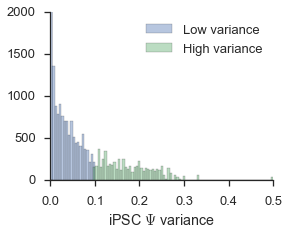

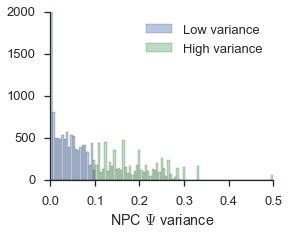

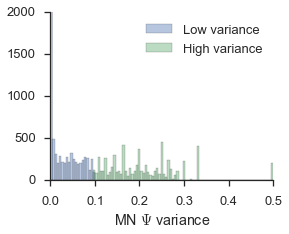

In [67]:
for phenotype in study.phenotype_order:
    fig, ax = plt.subplots(figsize=(4, 3))
    bins = np.linspace(0, variance.max().max(), 100)
    sns.distplot(low_variance[phenotype].dropna(), label='Low variance', kde=False, bins=bins, ax=ax)
    sns.distplot(high_variance[phenotype].dropna(), label='High variance', kde=False, bins=bins, ax=ax)
    ax.set(ylim=(0, 2000), xlabel='{} $\Psi$ variance'.format(phenotype))
    ax.legend()
    sns.despine()
    fig.savefig('{}/variance_histogram_{}.pdf'.format(folder, phenotype))

iPSC
$0.0 \leq \Psi < 0.2$        5737
$0.2 \leq \Psi < 0.8$        3717
$0.8 \leq \Psi \leq 1.0$    26155
dtype: int64
NPC
$0.0 \leq \Psi < 0.2$        5825
$0.2 \leq \Psi < 0.8$        3760
$0.8 \leq \Psi \leq 1.0$    25801
dtype: int64
MN
$0.0 \leq \Psi < 0.2$        5673
$0.2 \leq \Psi < 0.8$        4392
$0.8 \leq \Psi \leq 1.0$    25384
dtype: int64


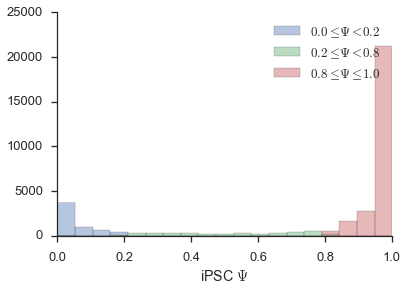

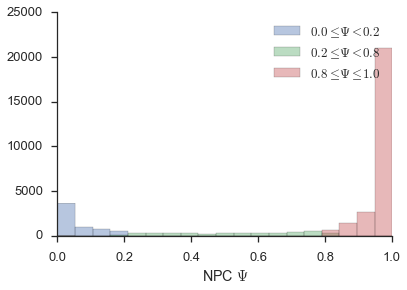

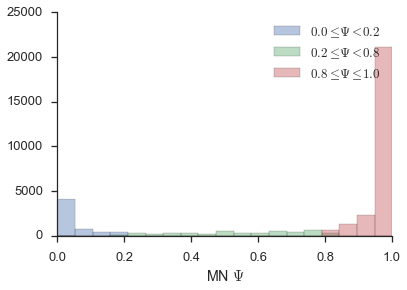

In [68]:
mean = study.splicing.singles.groupby(study.sample_id_to_phenotype).mean().T
mean_list = [mean[phenotype].dropna() for phenotype in study.phenotype_order]
mean_bins = (0, 0.2, 0.8, 1)

mean_label_order = ['$0.0 \leq \Psi < 0.2$', 
                    '$0.2 \leq \Psi < 0.8$', 
                    '$0.8 \leq \Psi \leq 1.0$']
mean_binned = mean.apply(pd.cut, bins=mean_bins, right=True, include_lowest=True, 
                         labels=mean_label_order)
mean_binned.head()


for phenotype in study.phenotype_order:
    fig, ax = plt.subplots(figsize=(6,4))
    bins = np.linspace(0, mean.max().max(), 20)
    grouped = mean[phenotype].groupby(mean_binned[phenotype])
    print grouped.size()
    for mean_bin, s in grouped:
#         print mean_bin
        sns.distplot(s.dropna(), label=mean_bin, kde=False, bins=bins, ax=ax)
    ax.set(xlabel='{} $\Psi$'.format(phenotype))
    ax.legend()
    sns.despine()
    fig.savefig('{}/psi_mean_histogram_{}.pdf'.format(folder, phenotype))

In [69]:
variance_bins = (0, variance_mean, variance.max().max().max())
variance_order = ['Low variance', 'High variance']

variance_bin_df = variance.apply(pd.cut, bins=variance_bins, labels=variance_order).apply(
    lambda x: pd.Series(x, index=variance.index))

variance_bin_tidy = pd.melt(variance_bin_df.reset_index(), value_name='variance_bin', id_vars='phenotype',
                           var_name='event_name').dropna()

variance_bin_tidy.head()

phenotype                                         event_name   variance_bin
2       iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...  High variance
5       iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...  High variance
8       iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...  High variance
11      iPSC  exon:chr10:100193697-100193848:-@exon:chr10:10...  High variance
14      iPSC  exon:chr10:100195392-100195529:-@exon:chr10:10...  High variance

In [70]:
mean_binned_df = mean_binned.apply(lambda x: pd.Series(x, index=mean.index))

mean_binned_tidy = pd.melt(mean_binned_df.reset_index(), value_name='mean_bin', id_vars='phenotype',
                           var_name='event_name')
mean_binned_tidy.head()

phenotype                                         event_name  \
0        MN  exon:chr10:100190328-100190427:-@exon:chr10:10...   
1       NPC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
2      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
3        MN  exon:chr10:100190328-100190427:-@exon:chr10:10...   
4       NPC  exon:chr10:100190328-100190427:-@exon:chr10:10...   

                mean_bin  
0  $0.0 \leq \Psi < 0.2$  
1                    NaN  
2  $0.2 \leq \Psi < 0.8$  
3  $0.0 \leq \Psi < 0.2$  
4                    NaN

In [71]:
merge_cols = ['phenotype', 'event_name']

mean_and_variance_tidy = mean_binned_tidy.merge(variance_bin_tidy, left_on=merge_cols, right_on=merge_cols)
mean_and_variance_tidy.head()

phenotype                                         event_name  \
0      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
1      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
2      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
3      iPSC  exon:chr10:100193697-100193848:-@exon:chr10:10...   
4      iPSC  exon:chr10:100195392-100195529:-@exon:chr10:10...   

                   mean_bin   variance_bin  
0     $0.2 \leq \Psi < 0.8$  High variance  
1     $0.2 \leq \Psi < 0.8$  High variance  
2     $0.2 \leq \Psi < 0.8$  High variance  
3  $0.8 \leq \Psi \leq 1.0$  High variance  
4  $0.8 \leq \Psi \leq 1.0$  High variance

In [72]:
mean_and_variance_tidy_with_features = mean_and_variance_tidy.join(study.splicing.feature_data,
                                                                  on='event_name')
mean_and_variance_tidy_with_features.head()

phenotype                                         event_name  \
0      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
1      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
2      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
3      iPSC  exon:chr10:100193697-100193848:-@exon:chr10:10...   
4      iPSC  exon:chr10:100195392-100195529:-@exon:chr10:10...   

                   mean_bin   variance_bin          gencode_id  \
0     $0.2 \leq \Psi < 0.8$  High variance  ENSG00000107521.14   
1     $0.2 \leq \Psi < 0.8$  High variance  ENSG00000107521.14   
2     $0.2 \leq \Psi < 0.8$  High variance  ENSG00000107521.14   
3  $0.8 \leq \Psi \leq 1.0$  High variance  ENSG00000107521.14   
4  $0.8 \leq \Psi \leq 1.0$  High variance  ENSG00000107521.14   

        ensembl_id gene_name  exon1_length  exon2_length  exon3_length  \
0  ENSG00000107521      HPS1           100            99           492   
1  ENSG00000107521      HPS1           100            99           487   
2  ENSG00000107521      HPS1           100            99            70   
3  ENSG00000107521      HPS1           152           161           100   
4  ENSG00000107521      HPS1           138           143           152   

          ...             rbp  ribosomal ribosomal_subunit  synapse  \
0         ...           False      False             False    False   
1         ...           False      False             False    False   
2         ...           False      False             False    False   
3         ...           False      False             False    False   
4         ...           False      False             False    False   

          tag       transcript_id transcript_name transcript_status  \
0  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   
1  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   
2  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   
3  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   
4  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   

  transcript_type transcription_factor  
0  protein_coding                False  
1  protein_coding                False  
2  protein_coding                False  
3  protein_coding                False  
4  protein_coding                False  

[5 rows x 48 columns]

### Plot CDFs and barplots of the splicing event features

In [73]:
mean_and_variance_tidy_with_features = mean_and_variance_tidy.join(study.splicing.feature_data,
                                                                  on='event_name')
mean_and_variance_tidy_with_features.head()

phenotype                                         event_name  \
0      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
1      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
2      iPSC  exon:chr10:100190328-100190427:-@exon:chr10:10...   
3      iPSC  exon:chr10:100193697-100193848:-@exon:chr10:10...   
4      iPSC  exon:chr10:100195392-100195529:-@exon:chr10:10...   

                   mean_bin   variance_bin          gencode_id  \
0     $0.2 \leq \Psi < 0.8$  High variance  ENSG00000107521.14   
1     $0.2 \leq \Psi < 0.8$  High variance  ENSG00000107521.14   
2     $0.2 \leq \Psi < 0.8$  High variance  ENSG00000107521.14   
3  $0.8 \leq \Psi \leq 1.0$  High variance  ENSG00000107521.14   
4  $0.8 \leq \Psi \leq 1.0$  High variance  ENSG00000107521.14   

        ensembl_id gene_name  exon1_length  exon2_length  exon3_length  \
0  ENSG00000107521      HPS1           100            99           492   
1  ENSG00000107521      HPS1           100            99           487   
2  ENSG00000107521      HPS1           100            99            70   
3  ENSG00000107521      HPS1           152           161           100   
4  ENSG00000107521      HPS1           138           143           152   

          ...             rbp  ribosomal ribosomal_subunit  synapse  \
0         ...           False      False             False    False   
1         ...           False      False             False    False   
2         ...           False      False             False    False   
3         ...           False      False             False    False   
4         ...           False      False             False    False   

          tag       transcript_id transcript_name transcript_status  \
0  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   
1  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   
2  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   
3  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   
4  ncRNA_host  ENSG00000107521.14            HPS1             KNOWN   

  transcript_type transcription_factor  
0  protein_coding                False  
1  protein_coding                False  
2  protein_coding                False  
3  protein_coding                False  
4  protein_coding                False  

[5 rows x 48 columns]

/home/obotvinnik/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2653: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)
/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


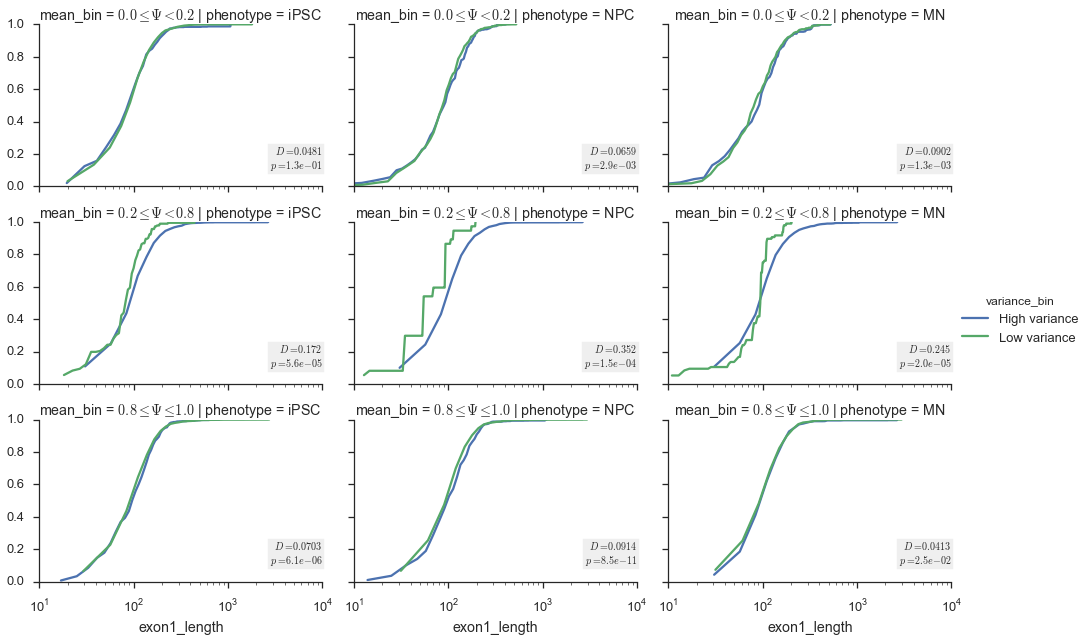

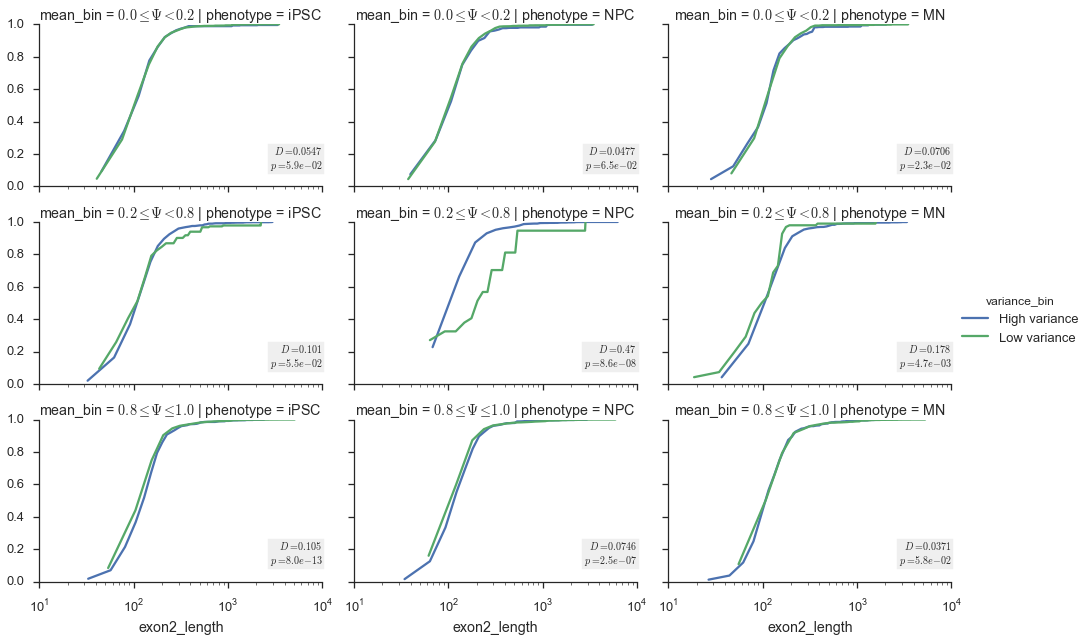

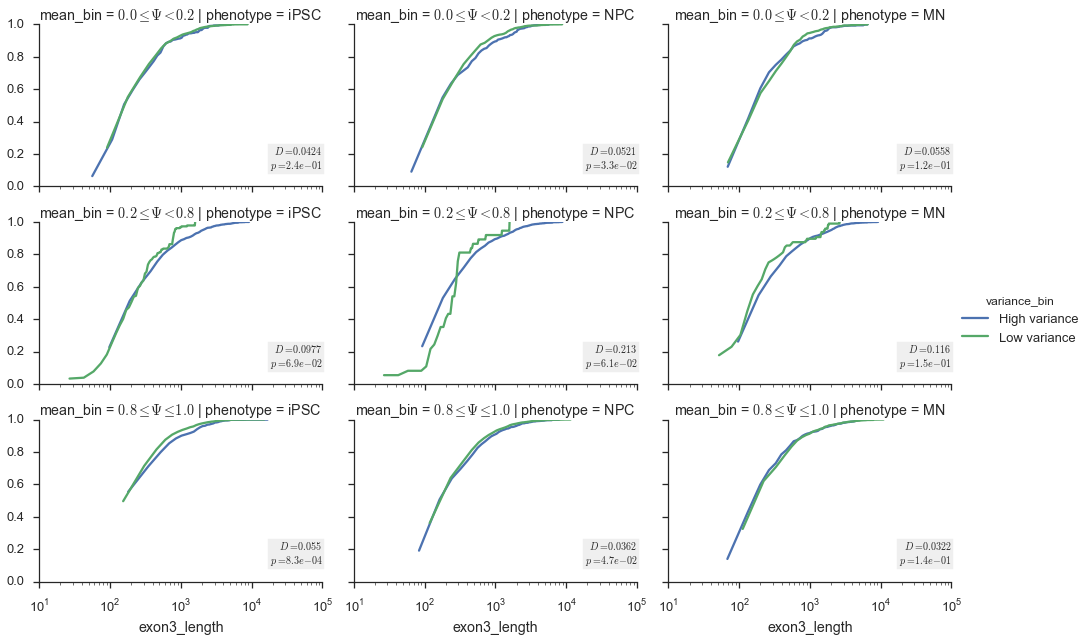

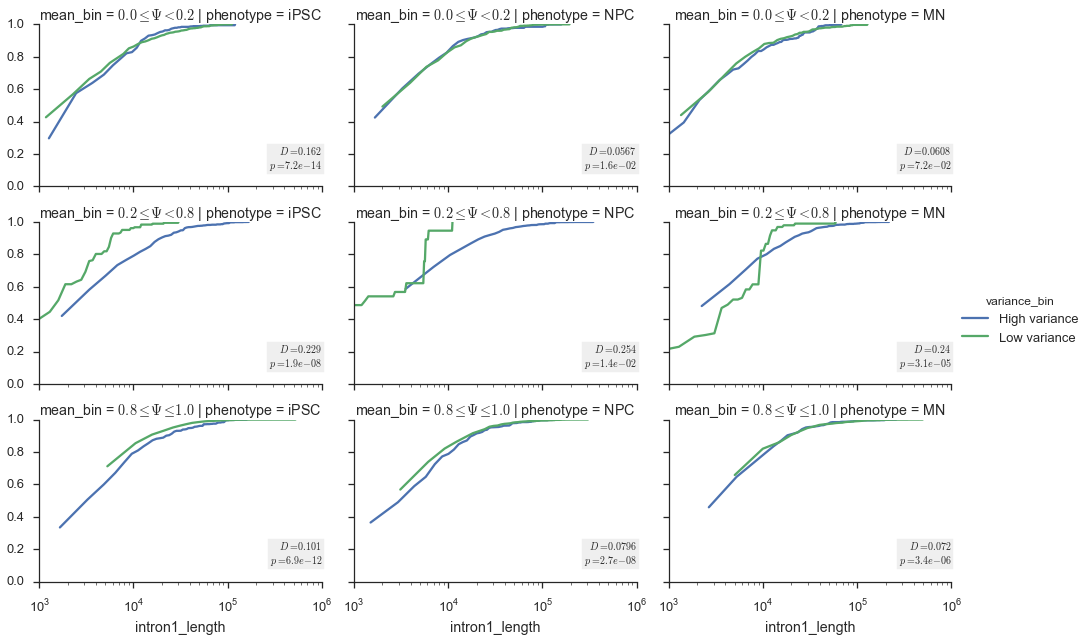

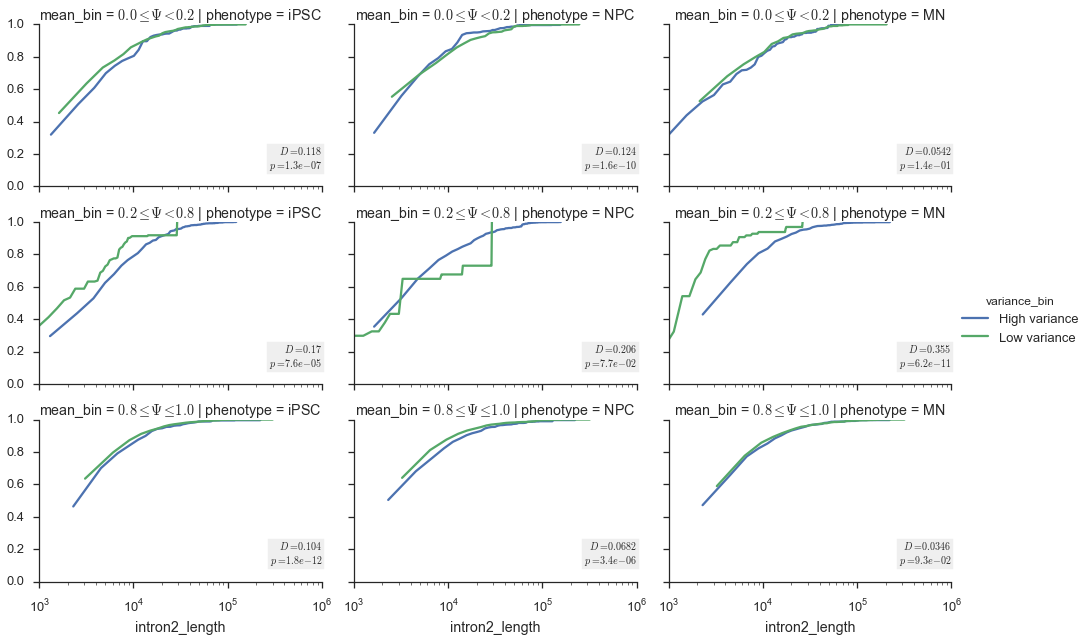

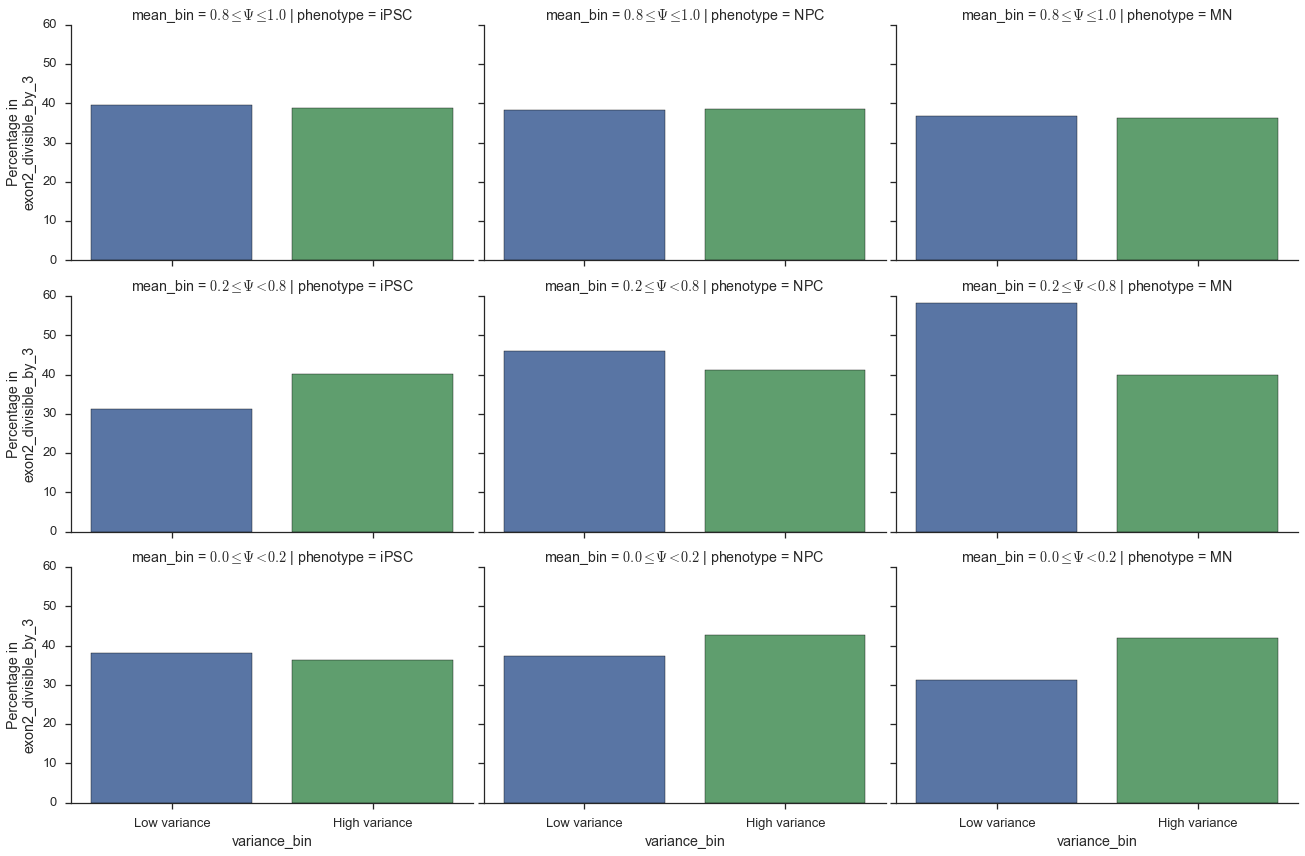

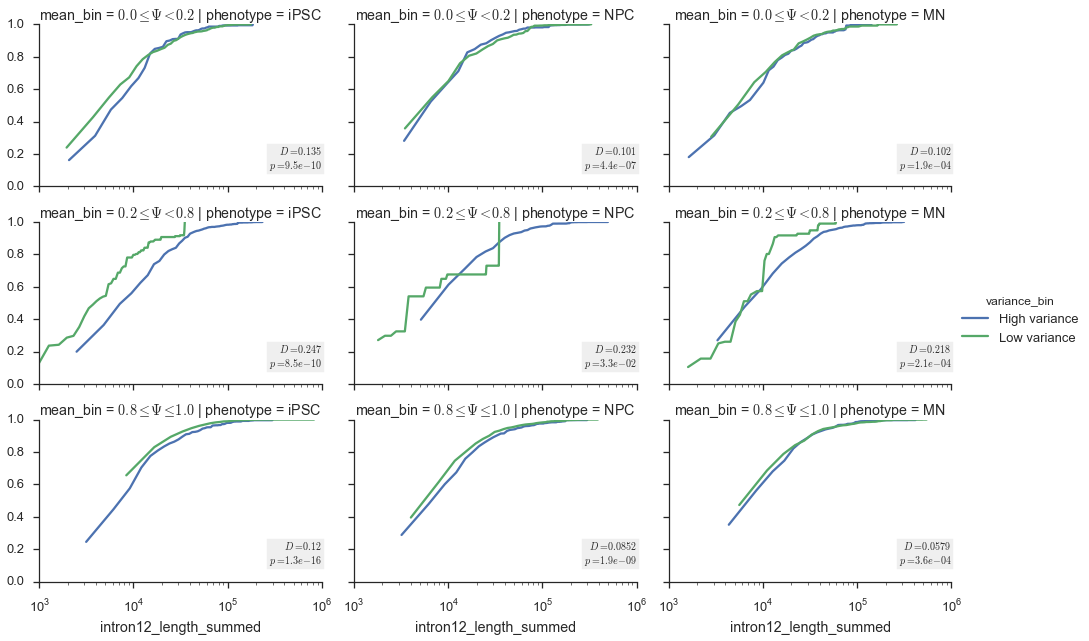

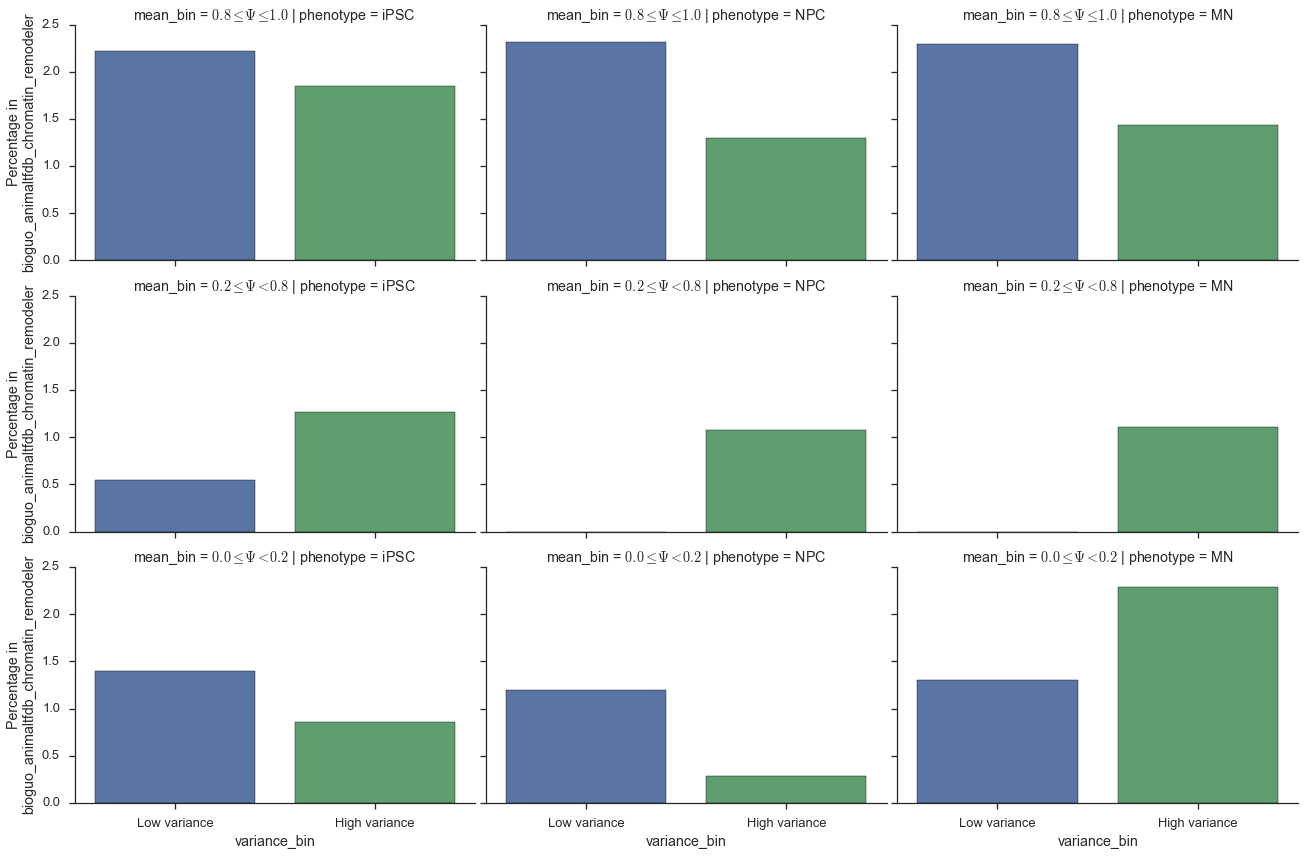

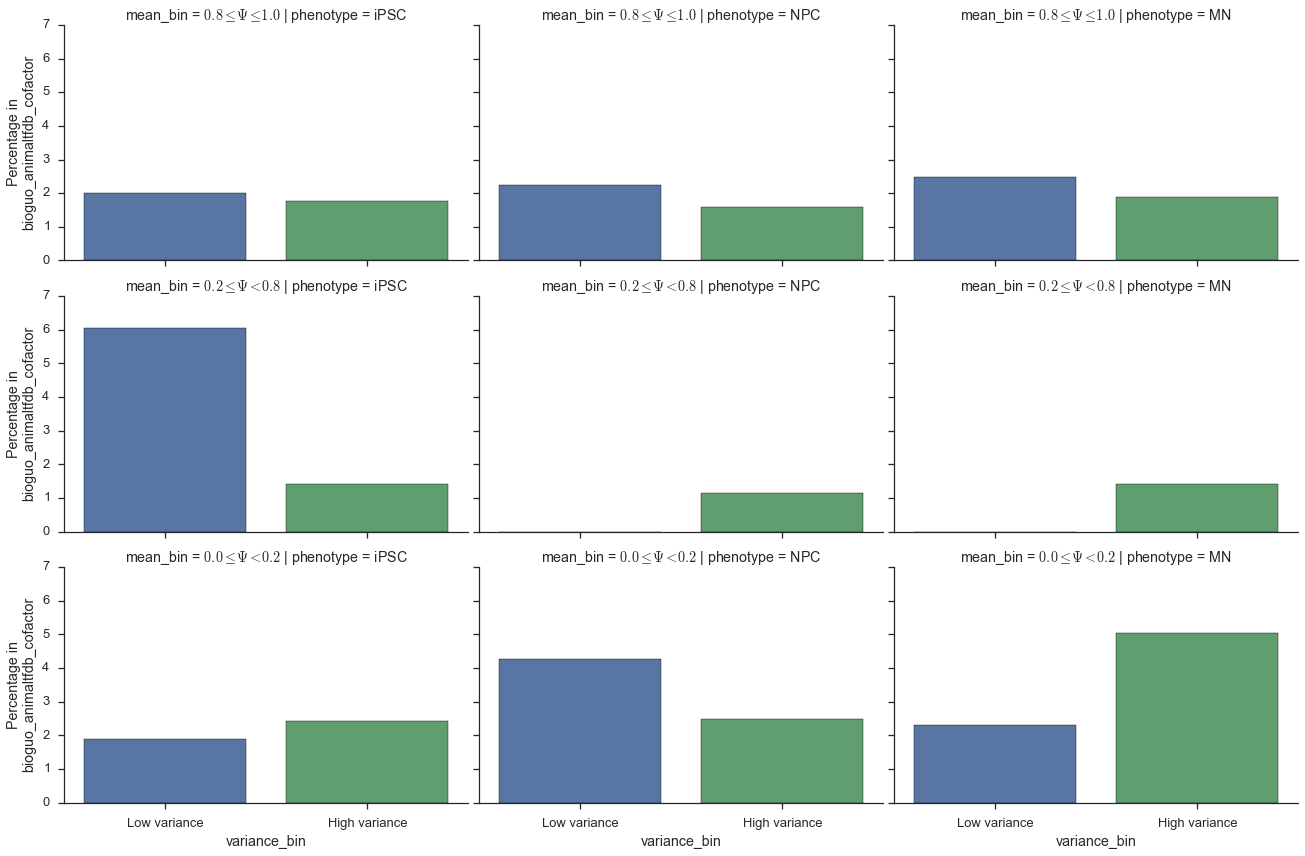

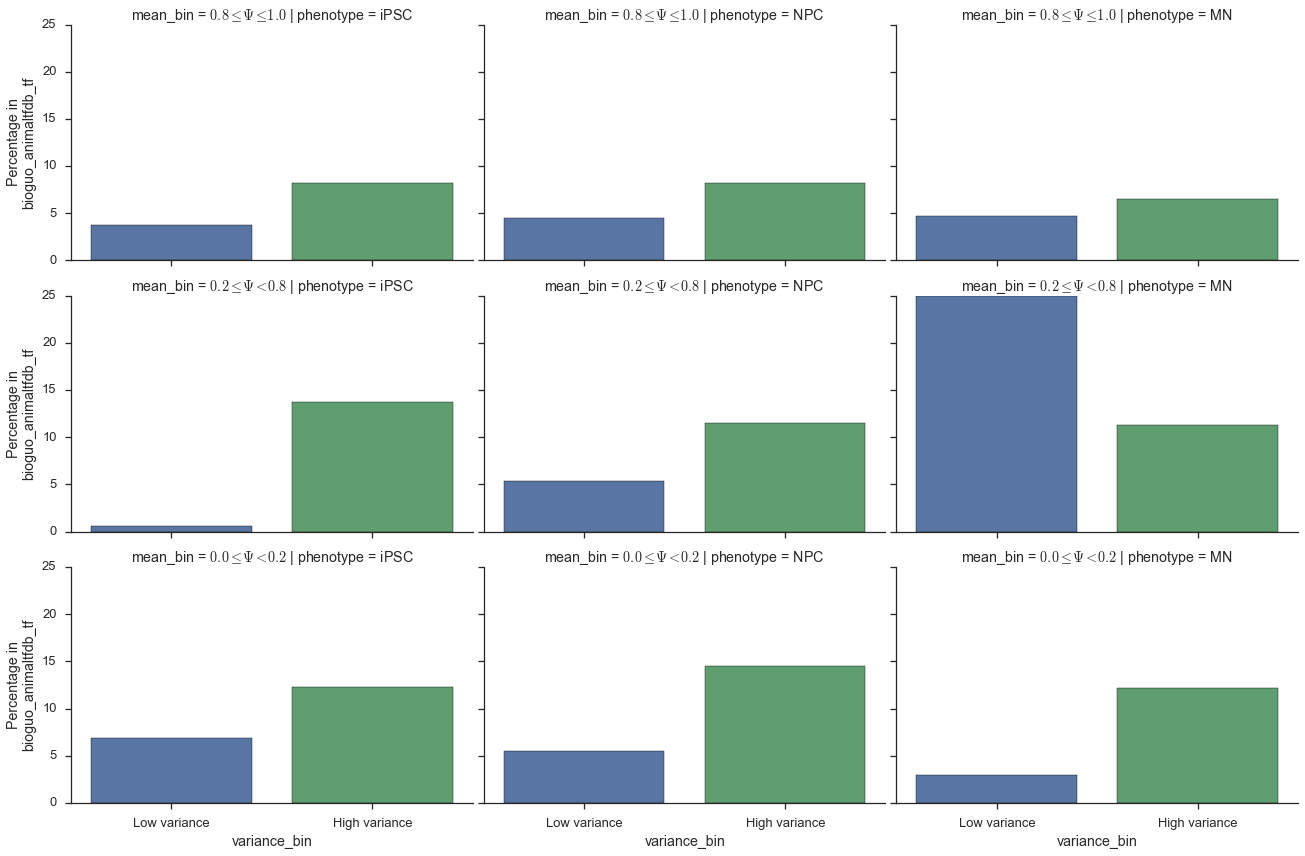

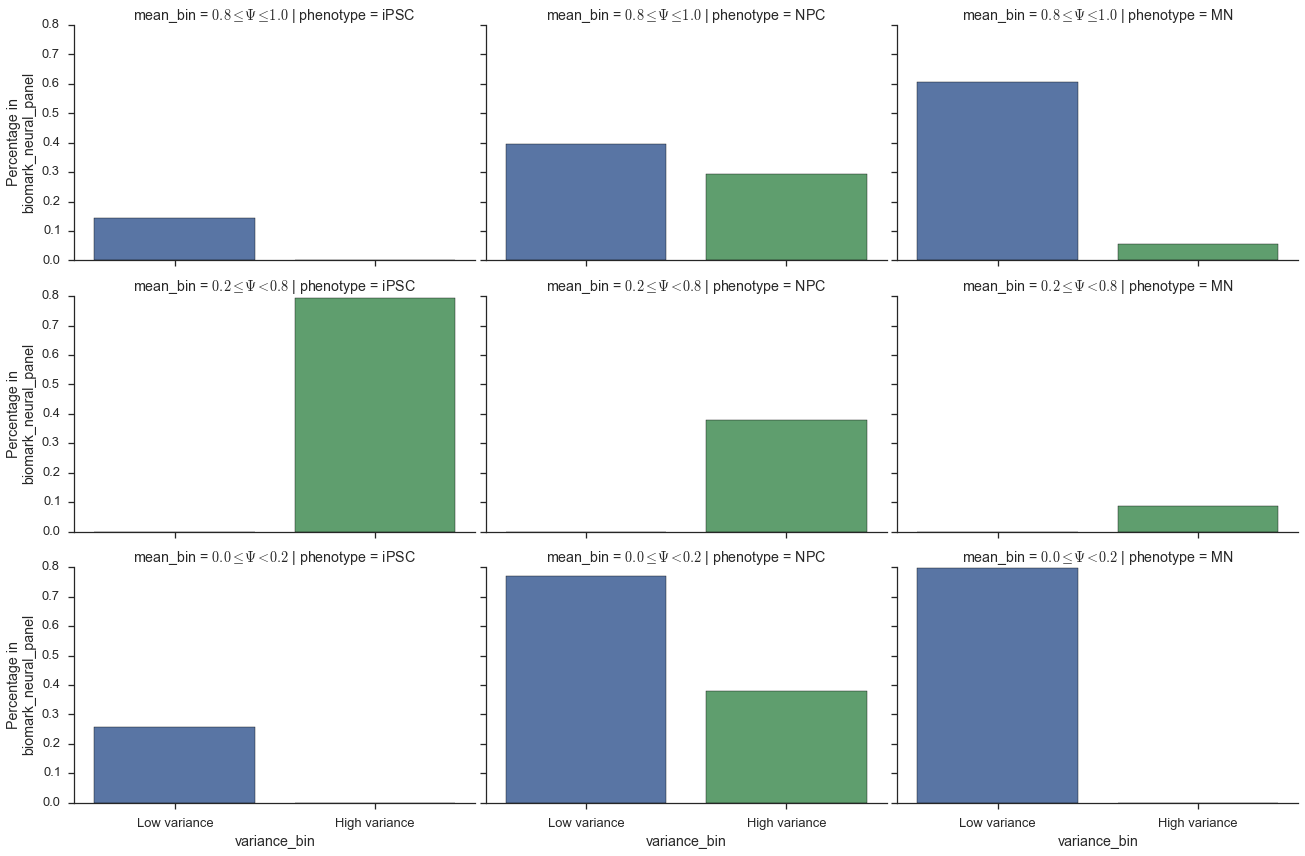

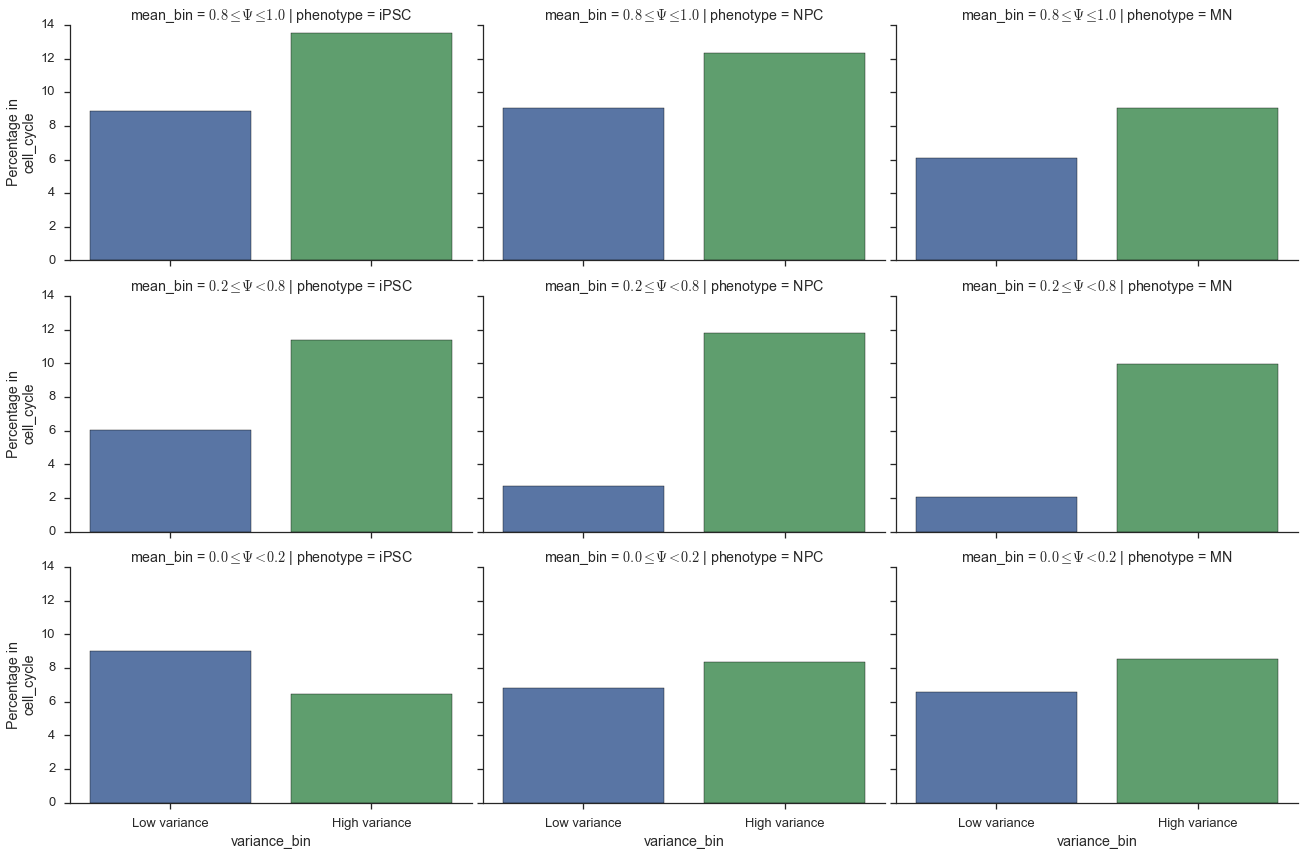

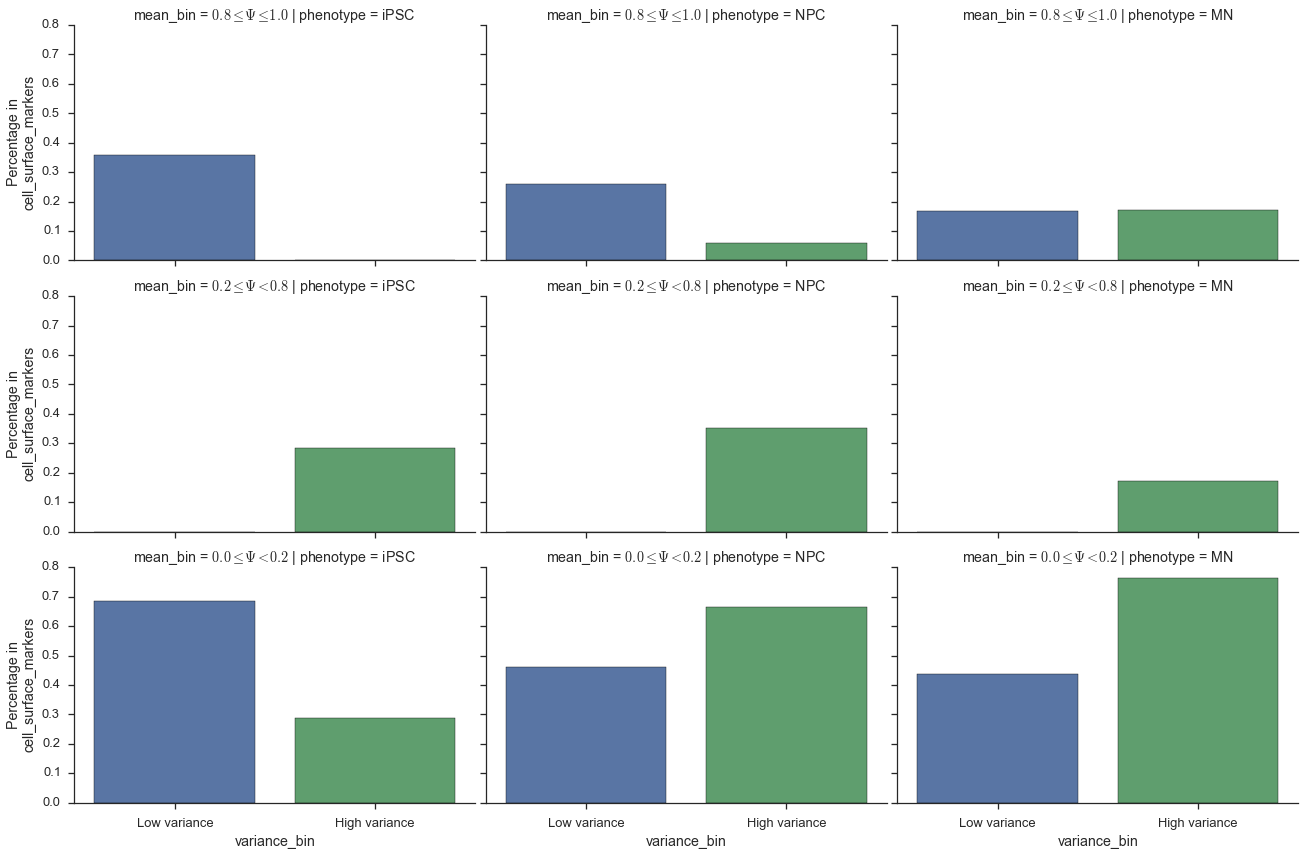

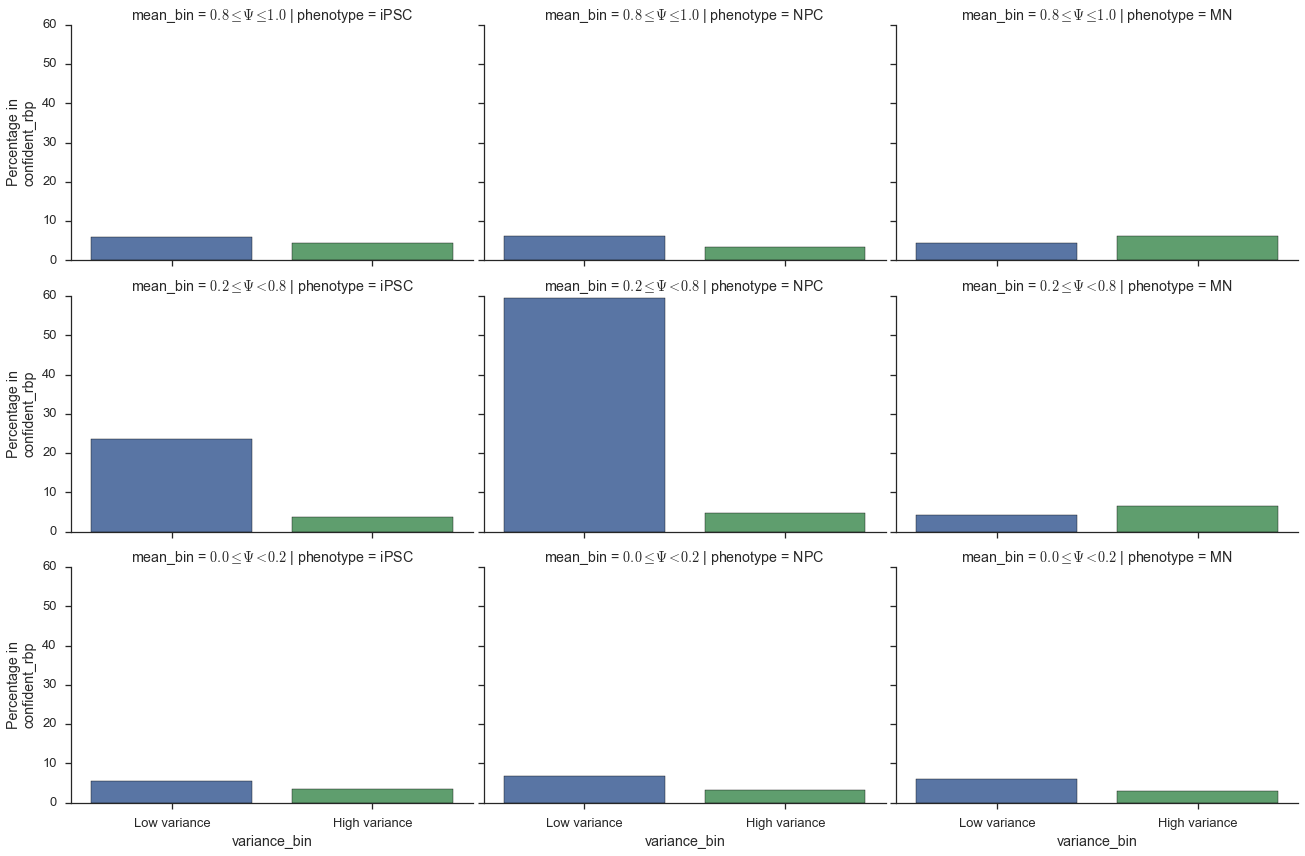

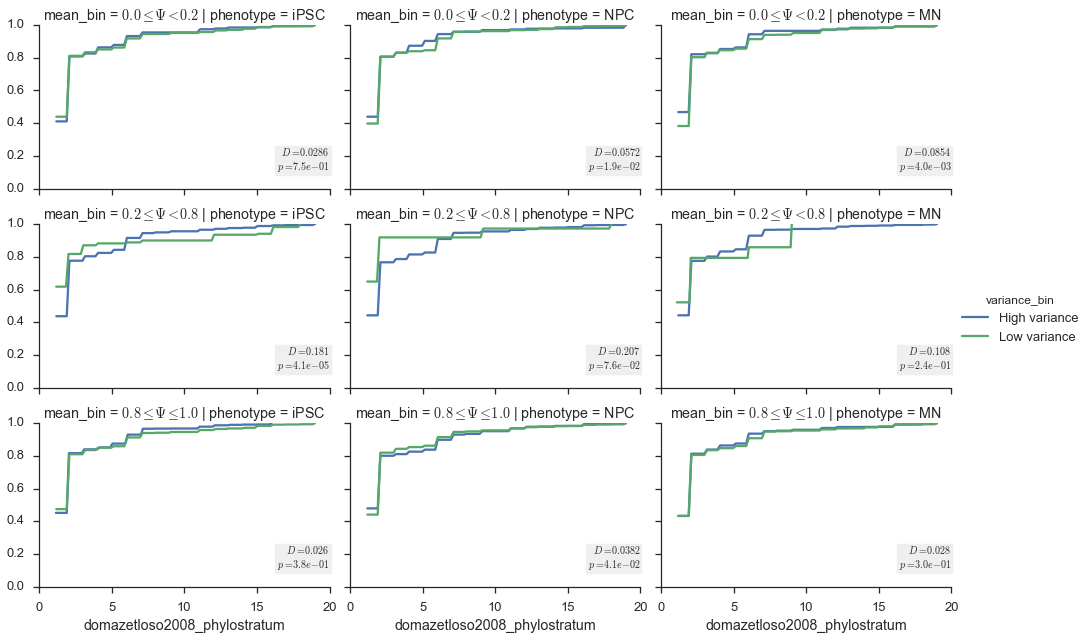

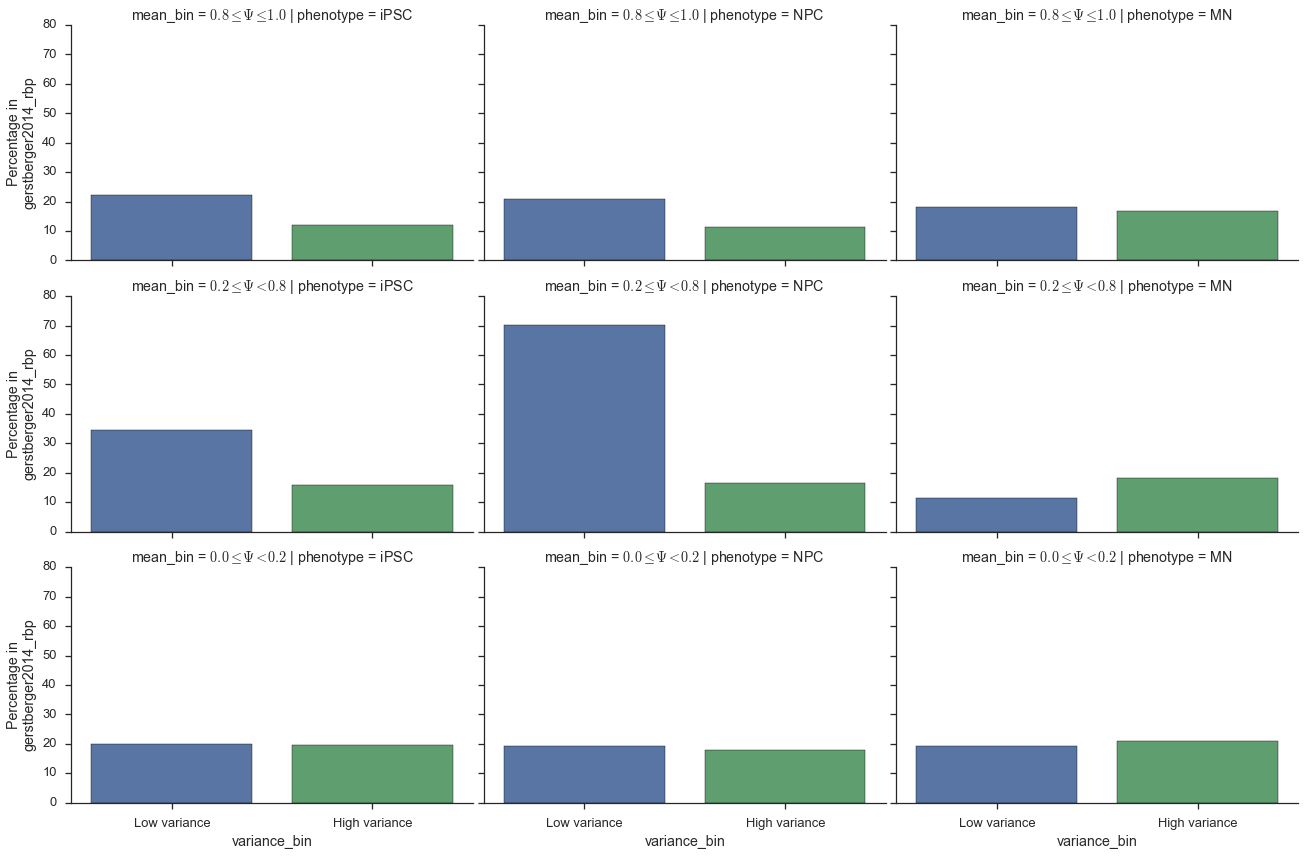

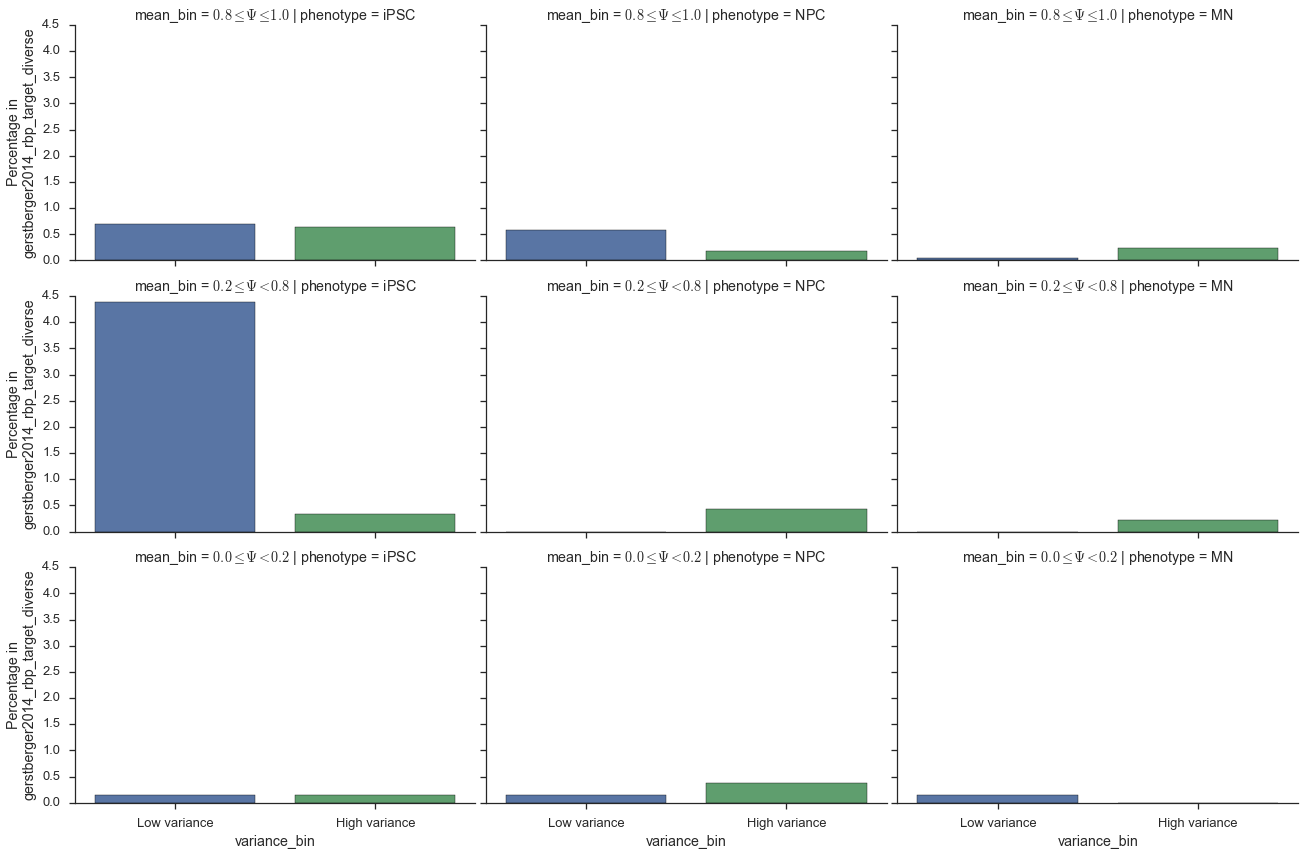

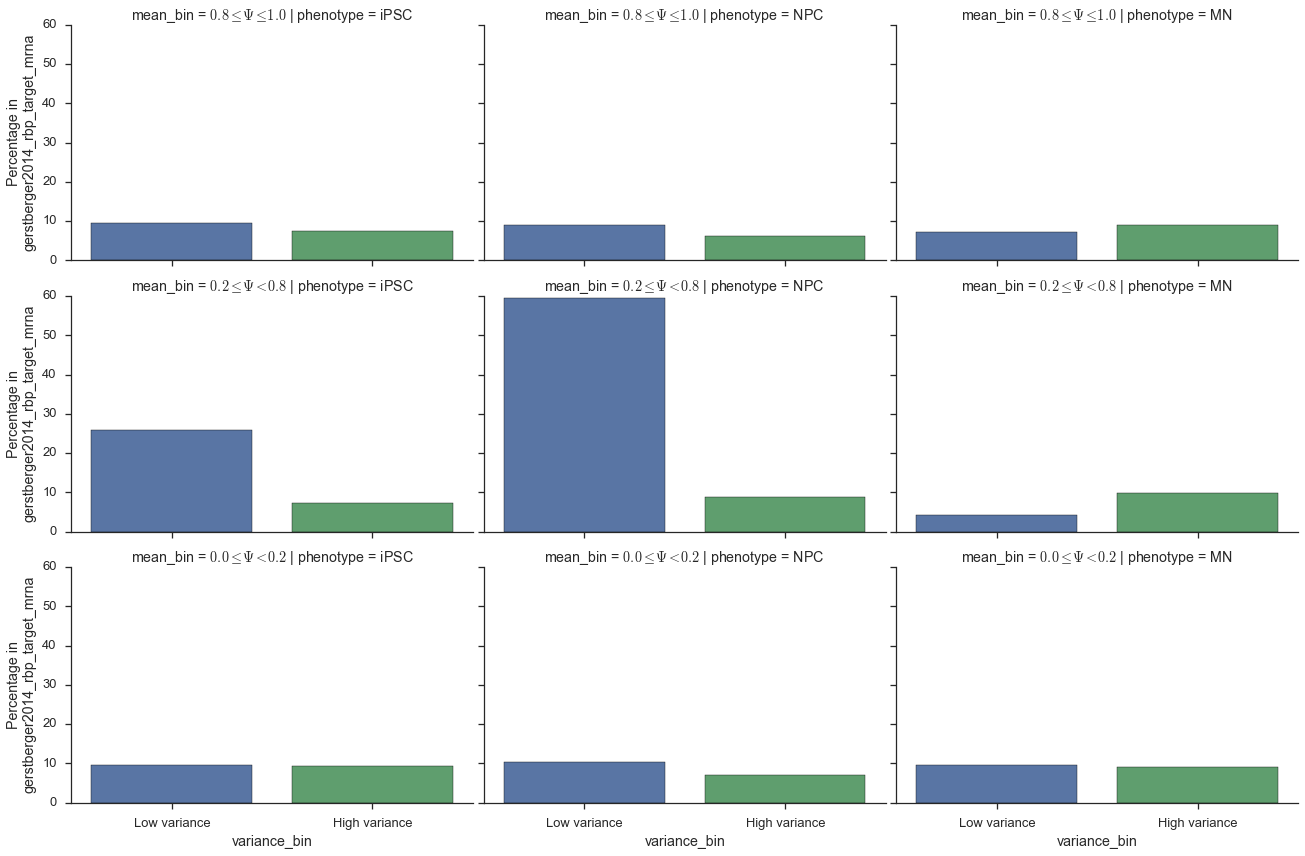

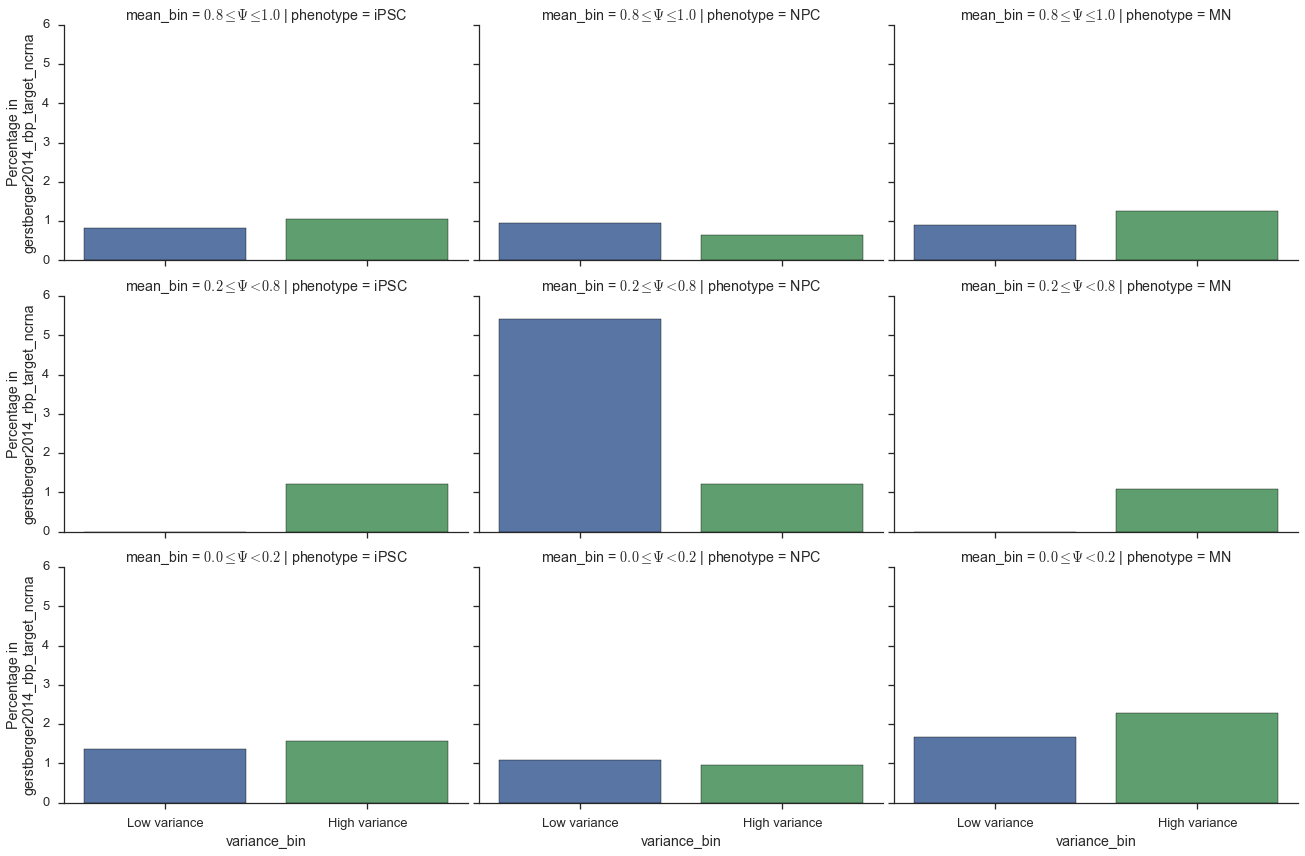

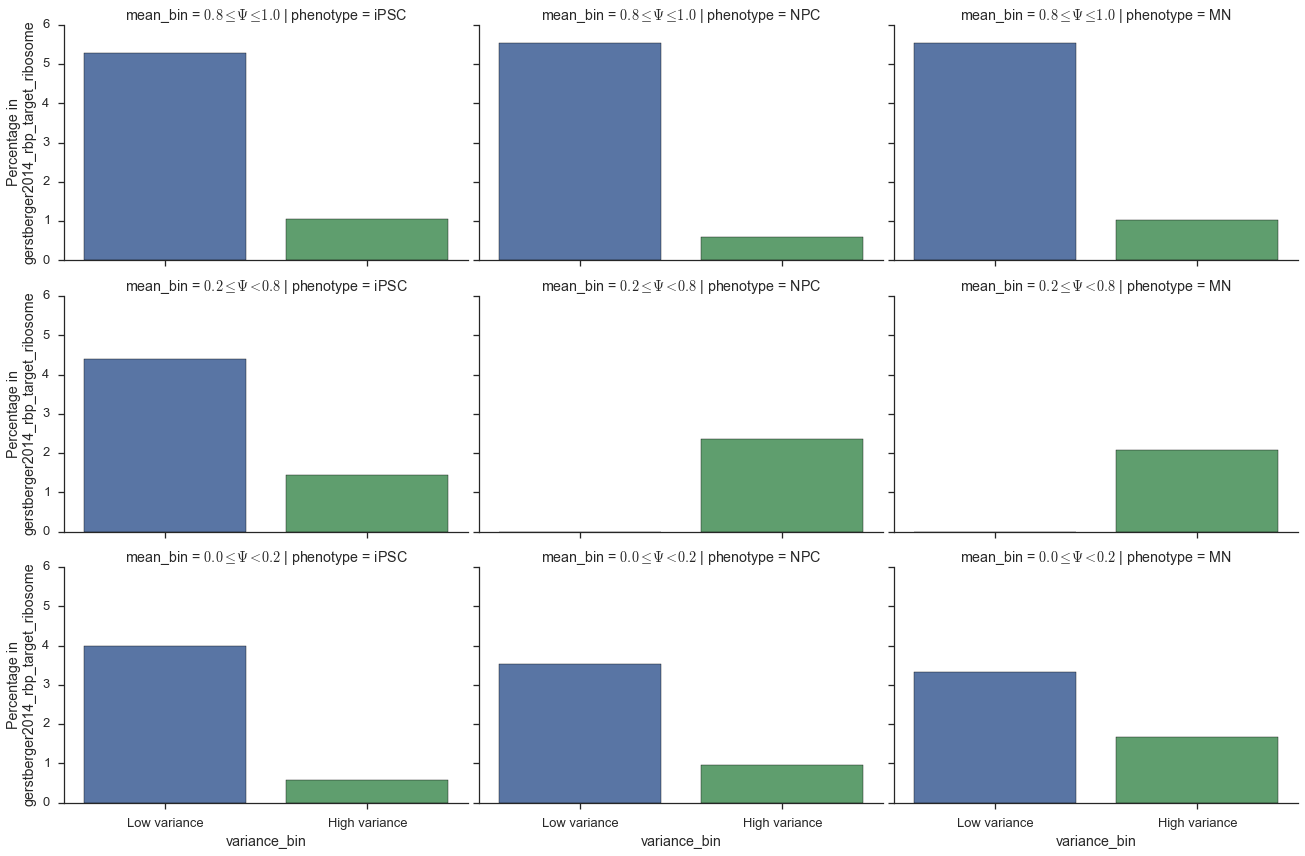

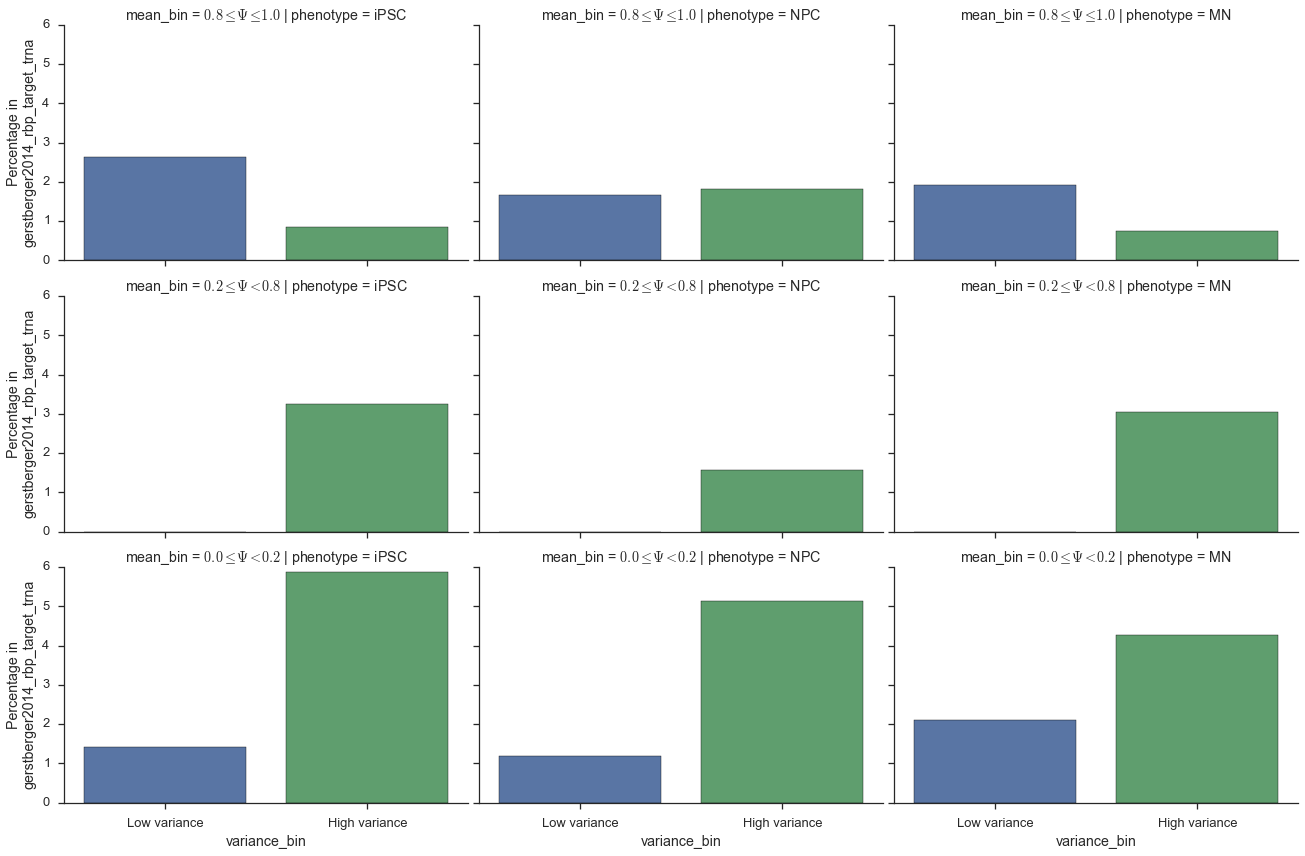

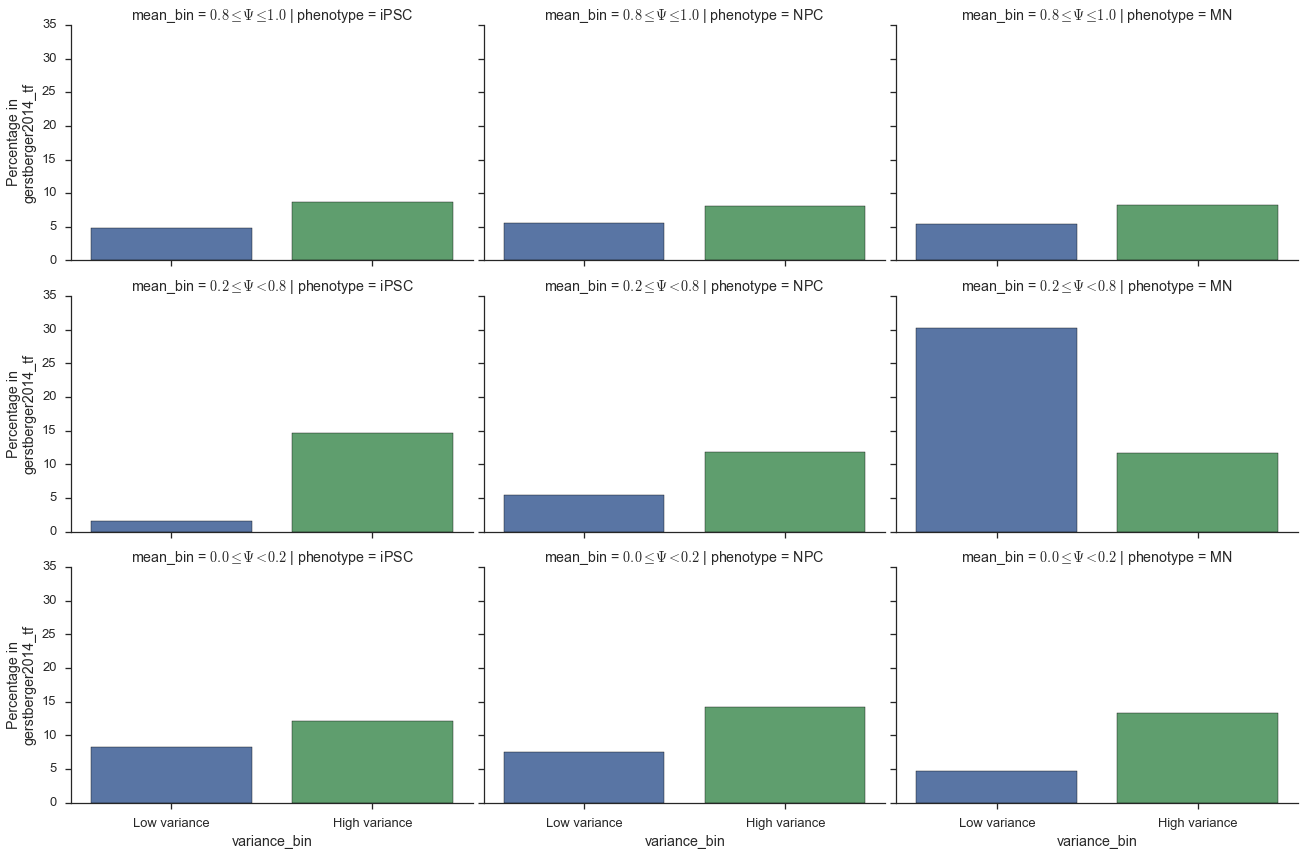

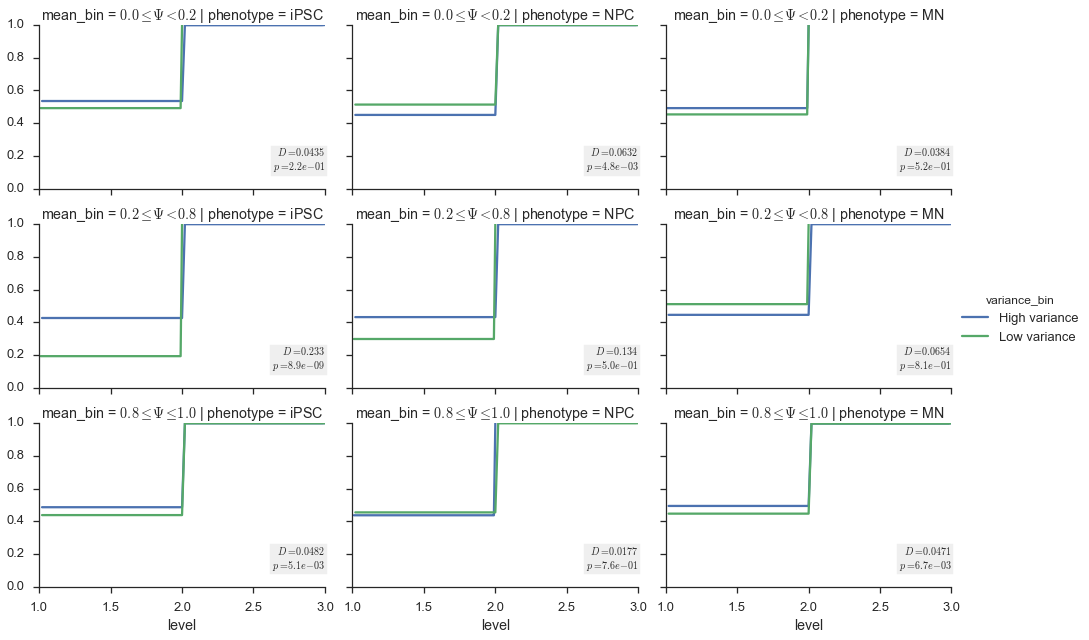

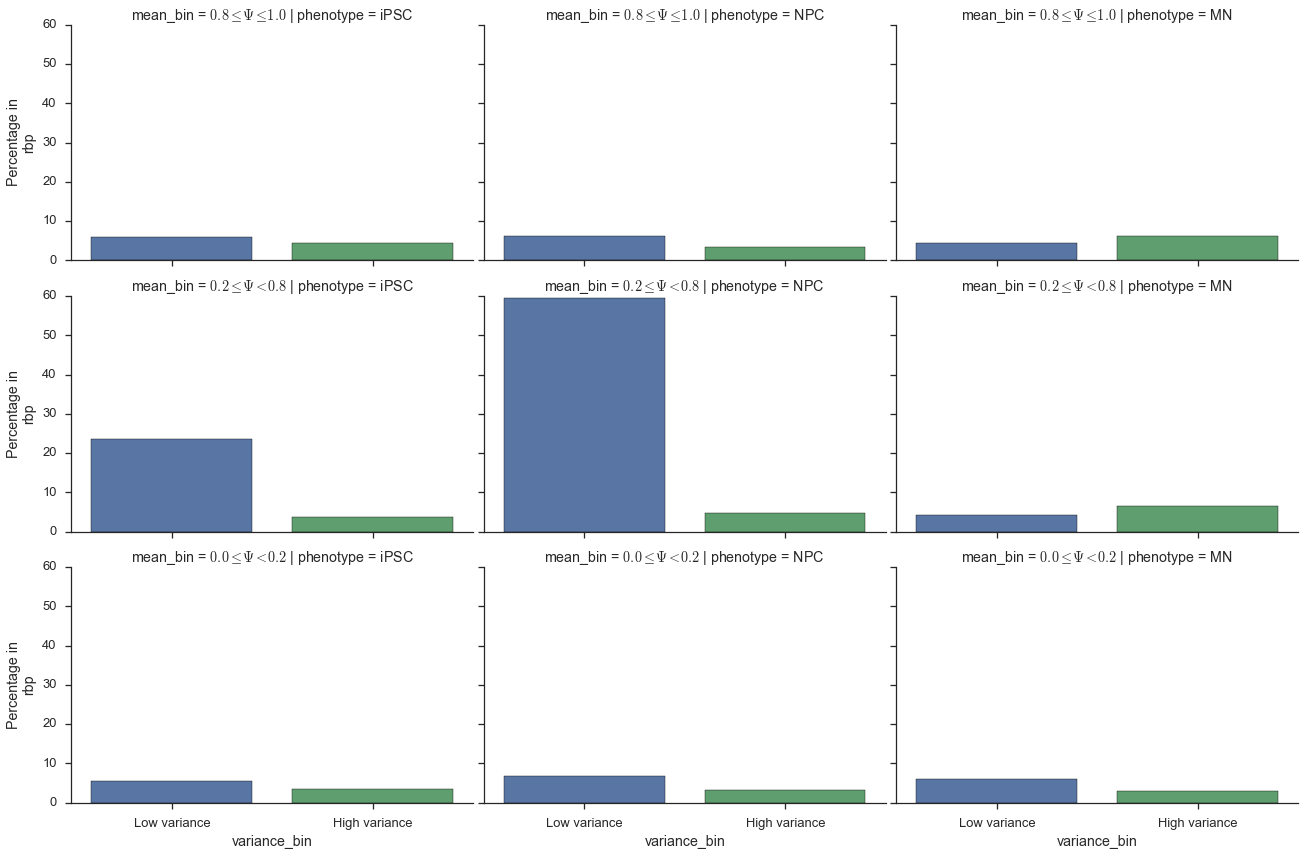

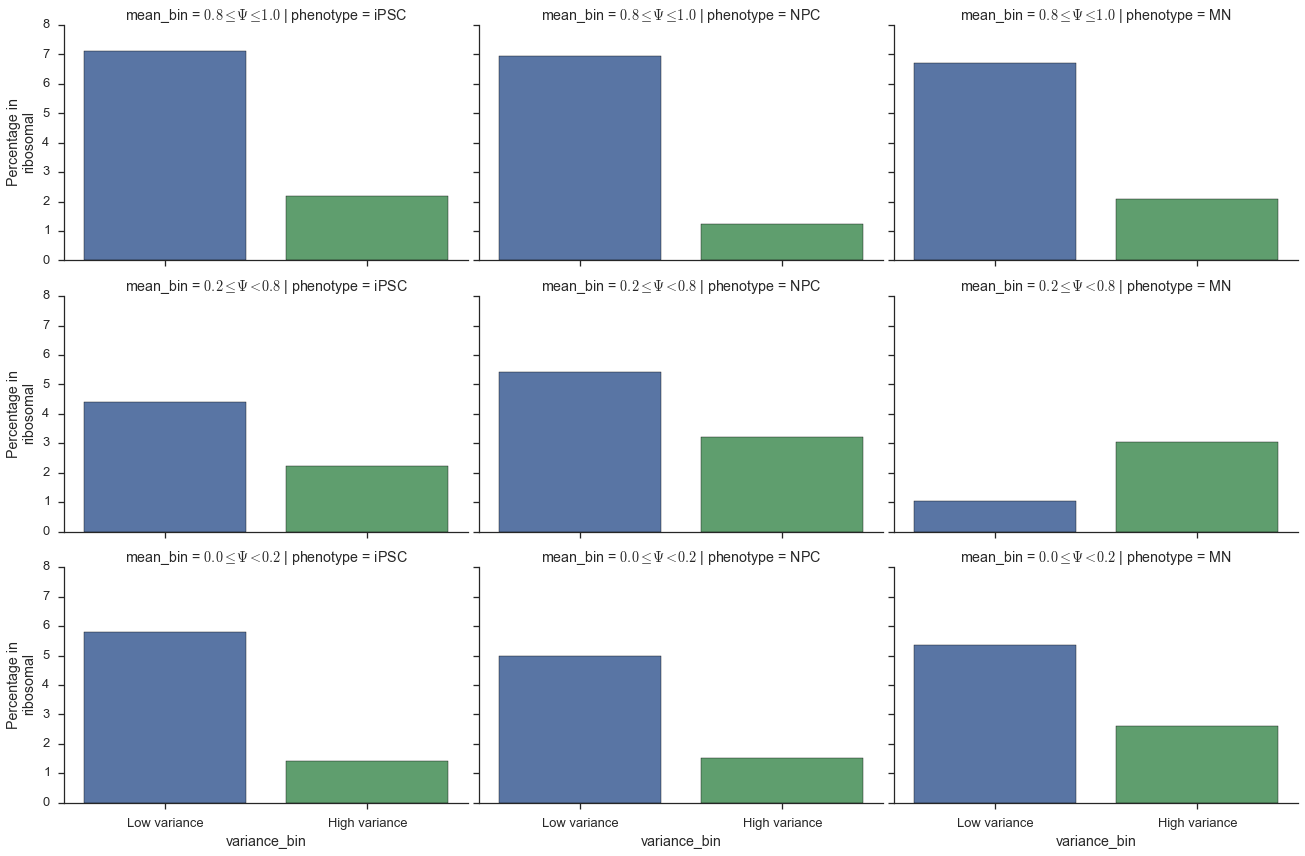

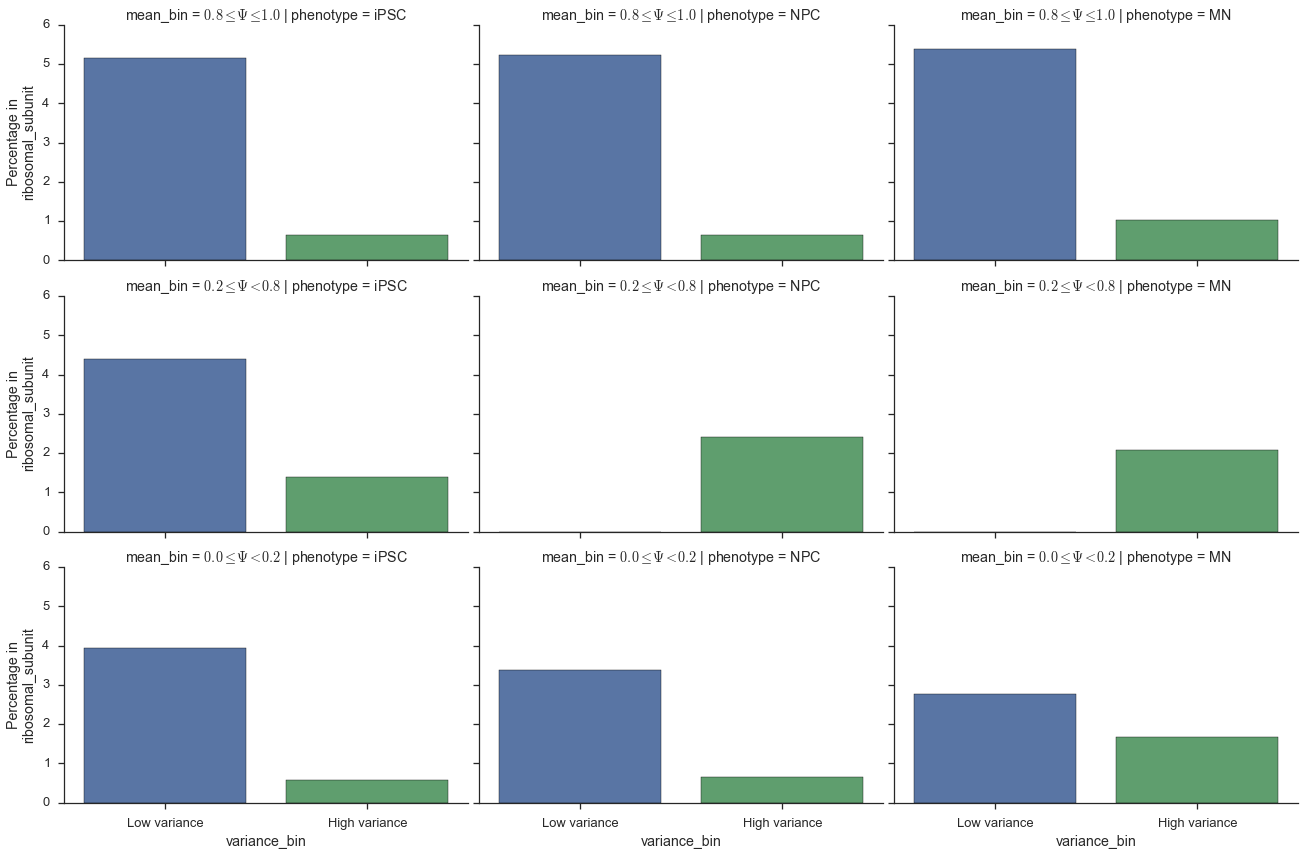

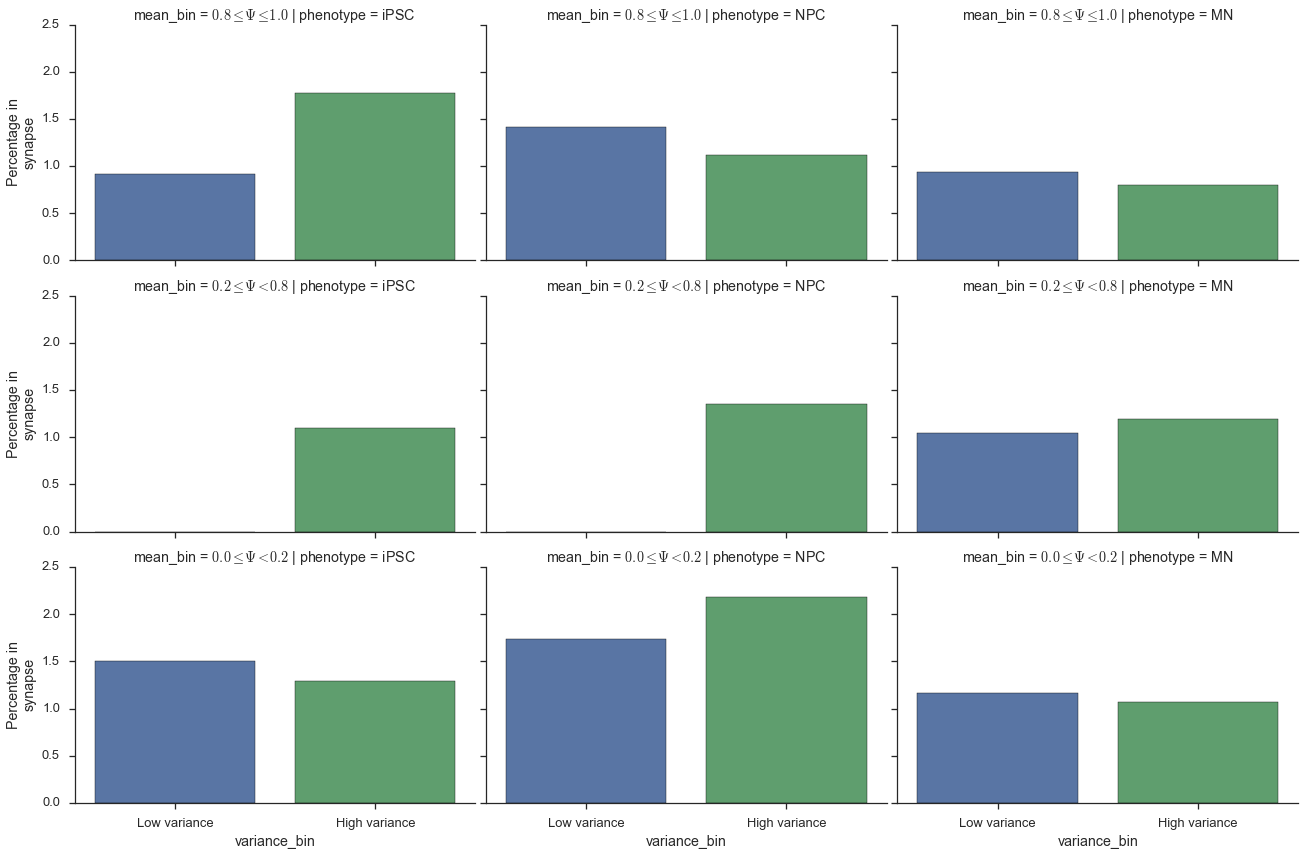

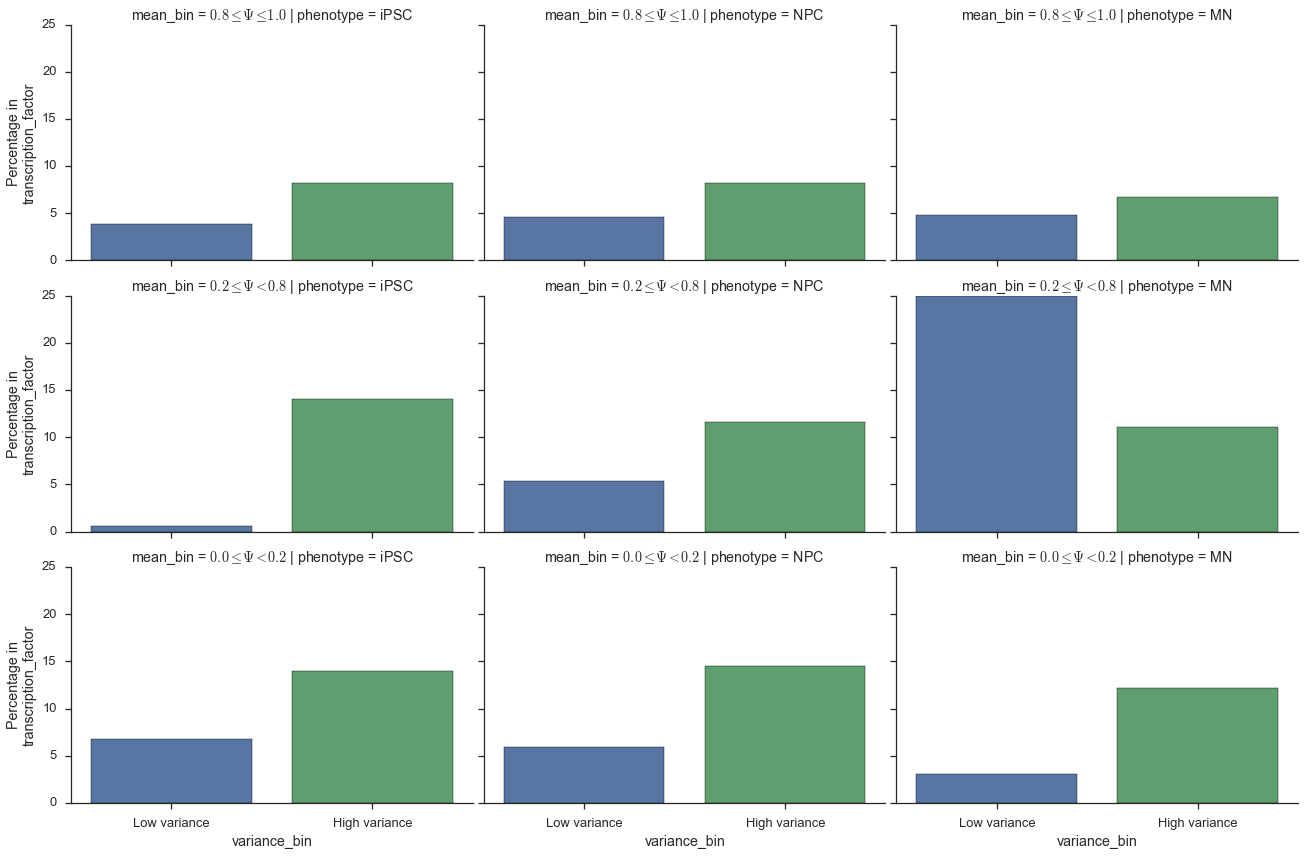

In [74]:
from scipy import stats

mean_label_order = list(reversed(['$0.0 \leq \Psi < 0.2$', 
                    '$0.2 \leq \Psi < 0.8$', 
                    '$0.8 \leq \Psi \leq 1.0$']))

def cdf(data, nbins=100):
    vmin = data.min()
    vmax = data.max()
    bins = np.linspace(vmin, vmax, nbins+1)
    hist, bin_edges = np.histogram(data, bins=nbins)
    normed_hist = hist/float(hist.sum())
#     print normed_hist.max(), normed_hist.sum()
    return bin_edges, np.cumsum(normed_hist)

def cdfplot(data, nbins=100, ax=None, log=False, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    bin_edges, cumulative = cdf(pd.Series(data), nbins=nbins)
    
#     if log:
#         bin_edges = np.log10(bin_edges)
#         ax.set_xlabel('log10')
    if log:
        return ax.semilogx(bin_edges[1:], cumulative, basex=10, **kwargs)
    else:
        return ax.plot(bin_edges[1:], cumulative, **kwargs)

for col in study.splicing.feature_data:
    if study.splicing.feature_data.dtypes[col] != object:
        if 'mod3' in col:
            continue
        data = mean_and_variance_tidy_with_features.dropna(subset=[col, 'variance_bin', 'phenotype', 'mean_bin'])
        if data.dtypes[col] != bool:
            fg = sns.FacetGrid(data, row='mean_bin', col='phenotype', hue='variance_bin', size=3,
                               col_order=study.phenotype_order, row_order=reversed(mean_label_order), aspect=1.5,
                              legend_out=True)
            log = 'length' in col
            fg.map(cdfplot, col, log=log)
            fg.set(ylim=(0, 1))

            data_categorical = data.copy()
            data_categorical[fg._row_var] = pd.Categorical(data_categorical[fg._row_var], 
                                                          categories=fg.row_names, ordered=True)
            data_categorical[fg._col_var] = pd.Categorical(data_categorical[fg._col_var], 
                                                          categories=fg.col_names, ordered=True)
            grouped = data_categorical.groupby([fg._row_var, fg._col_var])

            ks_results = [stats.ks_2samp(*[df2[col] for name2, df2 in 
                                            df1.groupby(fg._hue_var)]) for name, df1 in grouped]
#             print col, fg._row_var, fg._col_var, fg._x_var, ks_results
            for ax, (D, p_value) in zip(fg.axes.flat, ks_results):
                ax.annotate('$D = {:.3}$\n$p = {:.1e}$'.format(D, p_value), xy=(1, 0.1), xycoords='axes fraction',
                           ha='right', backgroundcolor='#EFEFEF')
            fg.add_legend()
            fg.savefig('{}/{}.pdf'.format(folder, col))
            
        else:
            grouped = data.groupby(['variance_bin', 'phenotype', 'mean_bin'])
            counts = grouped[col].sum()
            sizes = grouped[col].size()
            percentages = 100*counts/sizes
            tidy_df = percentages.reset_index()
            tidy_df = tidy_df.rename(columns={0:col})
            

            fg = sns.factorplot(x='variance_bin', col='phenotype', y=col,
                           data=tidy_df,
                           col_order=study.phenotype_order, row='mean_bin', kind='bar',
                           row_order=mean_label_order, x_order=variance_order, legend_out=True, size=4, aspect=1.5,
                          ci=None)
            fg.set_ylabels('Percentage in\n{}'.format(col))


            fg.savefig('{}/{}.pdf'.format(folder, col))